In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
#Uses gpu if available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(0)
batch_size = 128


train_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.482, 0.4465], std=[0.247, 0.2435, 0.2616]),
])

test_transform = transforms.ToTensor()

#Downloads datasets
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=train_transform) #Set download to true first time
class_names = dataset.classes

#Split for cross validation
train_size = 45000
val_size = 5000
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

val_dataset = torch.utils.data.Subset(
    torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=test_transform),
    val_dataset.indices
)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=test_transform)

#Creates DataLoaders for each set
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


In [4]:
#Defines class for a residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, halving):
        super().__init__()

        #If halving is true, the feature size is cut in half and the out_channels is doubled
        out_channels = in_channels
        stride1 = 1
        stride2 = 1
        if halving:
            out_channels *= 2
            stride1 = 2

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1), \
                                        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)) if halving else None

    def forward(self, x):
        #Keeps activation from previous layer to add as residual later
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        #Normal convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        #Adds residual
        x += identity
        out = F.relu(x)
        return out


In [5]:
#Defines Convolutional Neural Network

class Resnet(nn.Module):
    def __init__(self,):
        super().__init__()

        #Residual/Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.reslayers = nn.ModuleList()

        #Sets size of network. Paper uses n = {3,5,7,9}, but starting with smallest at 3
        n = 9

        for _ in range(n-1):
            self.reslayers.append(ResidualBlock(in_channels=16, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=16, kernel_size=3, halving=True))

        for _ in range(n-1):
            self.reslayers.append(ResidualBlock(in_channels=32, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=32, kernel_size=3, halving=True))

        for _ in range(n):
            self.reslayers.append(ResidualBlock(in_channels=64, kernel_size=3, halving=False))

        self.pool2 = nn.AvgPool2d(kernel_size=8,stride=1)

        #Fully connected layers
        self.flatten = nn.Flatten()
        self.out = nn.Linear(in_features=64, out_features=10)


    def forward(self, x):
        #Residual/Convolutional layers with ReLU activation function
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        for reslayer in self.reslayers:
            x = reslayer(x)

        x = self.pool2(x)

        #Fully connected layer with ReLU activation
        x = self.flatten(x)
        out = F.relu(self.out(x))
        
        return out

In [ ]:
#Iterates through a training epoch while displaying performance metrics by batch
def train_epoch(network, optimizer, criterion, scheduler):
    network.train(True)
    running_loss = 0.0
    running_accuracy = 0.0

    # Generate numpy arrays to save our training data and plot it
    save_every = 50
    batches = []
    losses = []
    accuracy = []
    batch_count_avg = 0

    for batch_index, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = network(inputs)
        num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += num_correct / batch_size

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        batch_count_avg += 1
        loss.backward()
        optimizer.step()

        if (batch_index+1) % save_every == 0:
            avg_loss_across_batches = running_loss / batch_count_avg
            avg_acc_across_batches = (running_accuracy / batch_count_avg) * 100
            batches.append(batch_index)
            losses.append(avg_loss_across_batches)
            accuracy.append(avg_acc_across_batches)
            print('Batch{0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1, avg_loss_across_batches, avg_acc_across_batches))
            running_loss = 0
            running_accuracy = 0
            batch_count_avg = 0

    scheduler.step()

    return batches, losses, accuracy

    

#Optional method to evaluate performance on validation data
def validate_epoch(network, criterion):
    network.train(False)
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = network(inputs)
            num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += num_correct / batch_size

            loss = criterion(outputs, labels)
            running_loss += loss.item()


    avg_loss_across_batches = running_loss / len(valloader)
    avg_accuracy_across_batches = (running_accuracy / len(valloader)) * 100
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches, avg_accuracy_across_batches))
    print('*****************************************')
    print()

    return avg_loss_across_batches, avg_accuracy_across_batches
            

In [8]:
def new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation):
    fig, ax = plt.subplots(4, 1, sharex=True)
    ax[0].clear()
    ax[0].plot(batches_training, losses_training, label='Training Loss', color='blue')
    ax[0].set_ylabel('Train Loss')
    ax[0].relim()
    ax[0].autoscale_view()

    ax[1].clear()
    ax[1].plot(batches_training, accuracies_training, label='Training Accuracies', color='blue')
    ax[1].set_ylabel('Train Accuracy')
    ax[1].relim()
    ax[1].autoscale_view()

    ax[2].clear()
    ax[2].plot(batches_validation, losses_validation, label='Validation Loss', color='blue')
    ax[2].set_ylabel('Val Loss')
    ax[2].relim()
    ax[2].autoscale_view()

    ax[3].clear()
    ax[3].plot(batches_validation, accuracies_validation, label='Validation Accuracies', color='blue')
    ax[3].set_ylabel('Val Accuracy')
    ax[3].relim()
    ax[3].autoscale_view()
    
    ax[3].set_xlabel('Batch Number')
    ax[0].set_title('Training and Validation Loss Over Time')

    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.pause(0.1)  # Adjust to control the update speed
    return fig

Epoch 1
Batch50, Loss: 2.267, Accuracy: 13.4%
Batch100, Loss: 2.246, Accuracy: 13.7%
Batch150, Loss: 2.223, Accuracy: 14.3%
Batch200, Loss: 2.235, Accuracy: 14.3%
Batch250, Loss: 2.225, Accuracy: 14.3%
Batch300, Loss: 2.204, Accuracy: 15.7%
Batch350, Loss: 2.200, Accuracy: 15.6%
Val Loss: 2.678, Val Accuracy: 14.7%
*****************************************



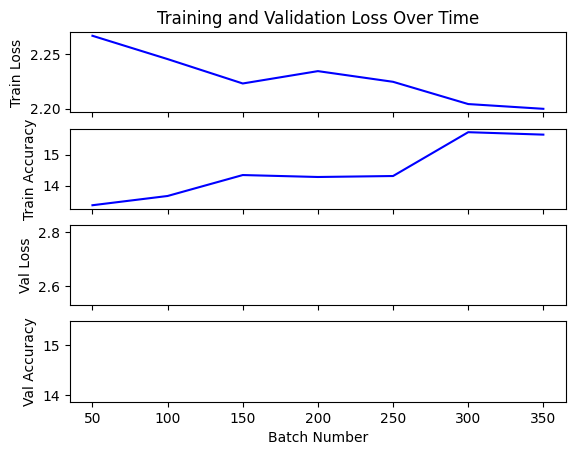

Epoch 2
Batch50, Loss: 2.197, Accuracy: 16.3%
Batch100, Loss: 2.201, Accuracy: 15.3%
Batch150, Loss: 2.194, Accuracy: 16.5%
Batch200, Loss: 2.175, Accuracy: 16.8%
Batch250, Loss: 2.181, Accuracy: 17.0%
Batch300, Loss: 2.164, Accuracy: 17.7%
Batch350, Loss: 2.162, Accuracy: 17.7%
Val Loss: 2.415, Val Accuracy: 13.4%
*****************************************



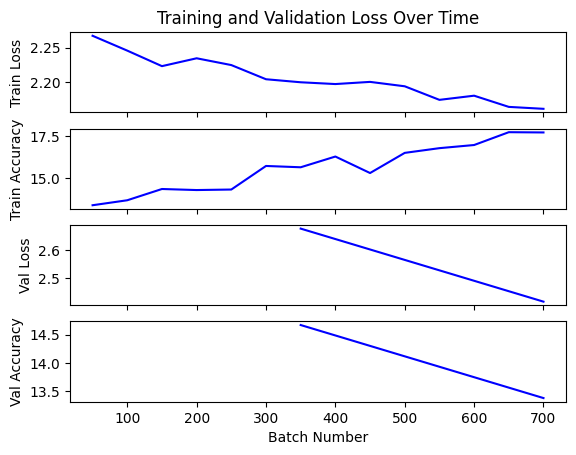

Epoch 3
Batch50, Loss: 2.145, Accuracy: 18.3%
Batch100, Loss: 2.148, Accuracy: 18.5%
Batch150, Loss: 2.152, Accuracy: 18.3%
Batch200, Loss: 2.149, Accuracy: 17.9%
Batch250, Loss: 2.149, Accuracy: 17.9%
Batch300, Loss: 2.146, Accuracy: 18.1%
Batch350, Loss: 2.136, Accuracy: 19.0%
Val Loss: 2.263, Val Accuracy: 11.3%
*****************************************



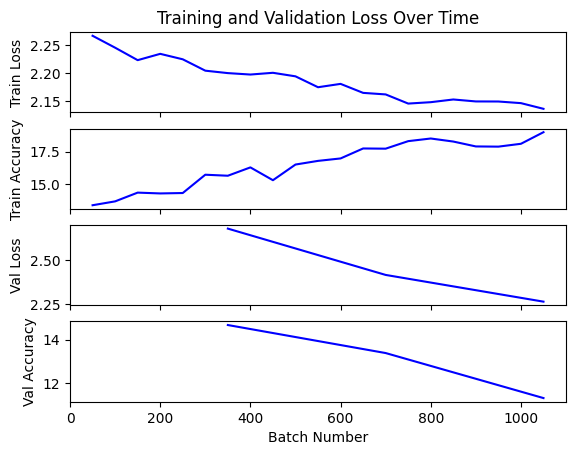

Epoch 4
Batch50, Loss: 2.106, Accuracy: 20.5%
Batch100, Loss: 2.125, Accuracy: 19.1%
Batch150, Loss: 2.120, Accuracy: 19.5%
Batch200, Loss: 2.121, Accuracy: 18.8%
Batch250, Loss: 2.103, Accuracy: 19.5%
Batch300, Loss: 2.109, Accuracy: 19.1%
Batch350, Loss: 2.094, Accuracy: 19.7%
Val Loss: 2.503, Val Accuracy: 16.7%
*****************************************



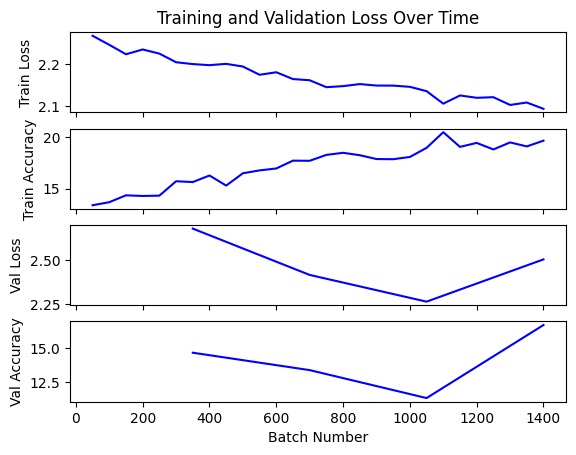

Epoch 5
Batch50, Loss: 2.091, Accuracy: 20.8%
Batch100, Loss: 2.088, Accuracy: 20.0%
Batch150, Loss: 2.073, Accuracy: 20.9%
Batch200, Loss: 2.078, Accuracy: 20.4%
Batch250, Loss: 2.063, Accuracy: 20.8%
Batch300, Loss: 2.087, Accuracy: 20.1%
Batch350, Loss: 2.062, Accuracy: 20.9%
Val Loss: 2.413, Val Accuracy: 15.1%
*****************************************



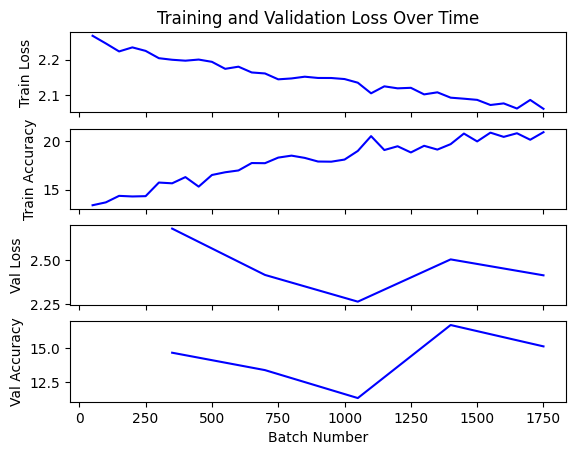

Epoch 6
Batch50, Loss: 2.055, Accuracy: 21.4%
Batch100, Loss: 2.072, Accuracy: 21.0%
Batch150, Loss: 2.056, Accuracy: 21.8%
Batch200, Loss: 2.037, Accuracy: 21.8%
Batch250, Loss: 2.041, Accuracy: 21.8%
Batch300, Loss: 2.036, Accuracy: 22.0%
Batch350, Loss: 2.036, Accuracy: 21.8%
Val Loss: 2.480, Val Accuracy: 14.5%
*****************************************



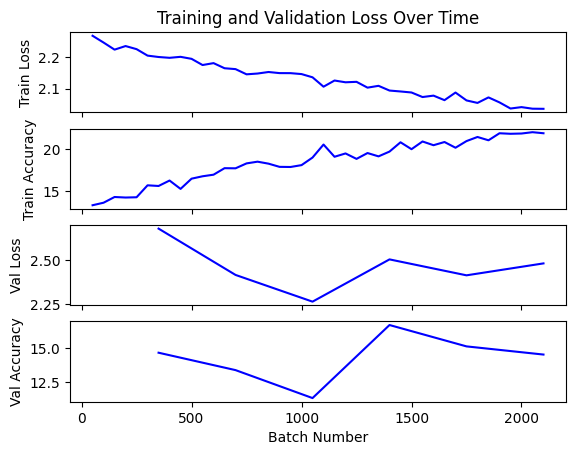

Epoch 7
Batch50, Loss: 2.039, Accuracy: 21.4%
Batch100, Loss: 2.010, Accuracy: 22.5%
Batch150, Loss: 2.017, Accuracy: 21.9%
Batch200, Loss: 2.024, Accuracy: 22.0%
Batch250, Loss: 1.998, Accuracy: 22.8%
Batch300, Loss: 1.993, Accuracy: 23.2%
Batch350, Loss: 2.004, Accuracy: 23.0%
Val Loss: 2.312, Val Accuracy: 20.4%
*****************************************



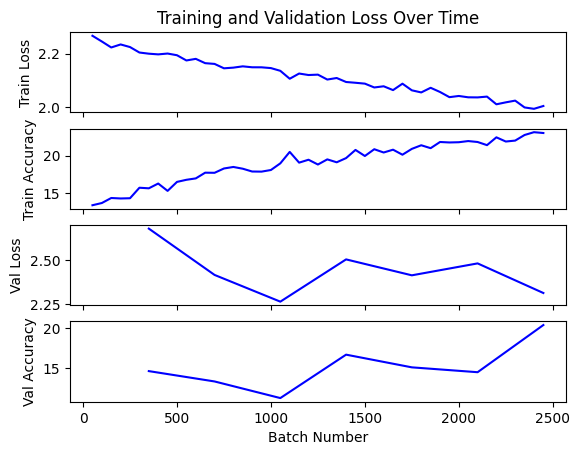

Epoch 8
Batch50, Loss: 1.994, Accuracy: 22.8%
Batch100, Loss: 1.973, Accuracy: 23.9%
Batch150, Loss: 1.983, Accuracy: 23.1%
Batch200, Loss: 1.964, Accuracy: 24.1%
Batch250, Loss: 1.985, Accuracy: 22.9%
Batch300, Loss: 1.980, Accuracy: 22.6%
Batch350, Loss: 1.967, Accuracy: 23.7%
Val Loss: 2.186, Val Accuracy: 17.7%
*****************************************



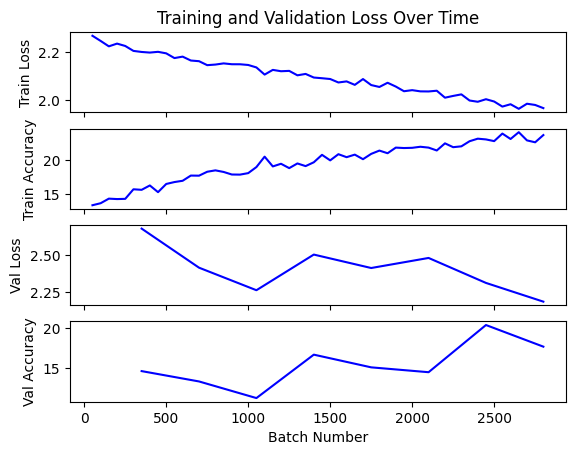

Epoch 9
Batch50, Loss: 1.963, Accuracy: 23.6%
Batch100, Loss: 1.946, Accuracy: 24.5%
Batch150, Loss: 1.951, Accuracy: 23.8%
Batch200, Loss: 1.956, Accuracy: 24.8%
Batch250, Loss: 1.949, Accuracy: 23.9%
Batch300, Loss: 1.947, Accuracy: 24.5%
Batch350, Loss: 1.940, Accuracy: 24.1%
Val Loss: 2.208, Val Accuracy: 20.0%
*****************************************



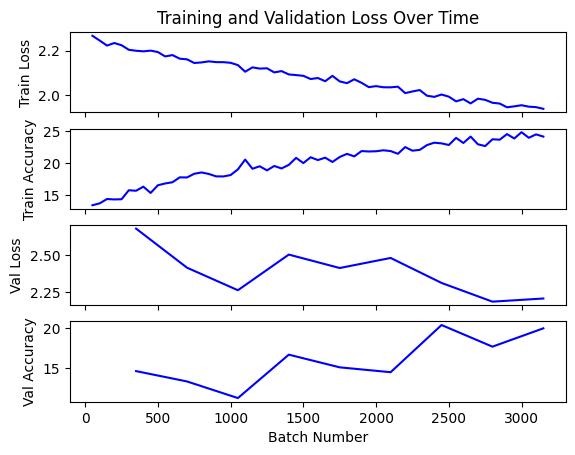

Epoch 10
Batch50, Loss: 1.935, Accuracy: 24.5%
Batch100, Loss: 1.936, Accuracy: 24.0%
Batch150, Loss: 1.938, Accuracy: 24.3%
Batch200, Loss: 1.925, Accuracy: 24.1%
Batch250, Loss: 1.930, Accuracy: 24.5%
Batch300, Loss: 1.938, Accuracy: 24.5%
Batch350, Loss: 1.928, Accuracy: 24.1%
Val Loss: 2.278, Val Accuracy: 19.1%
*****************************************



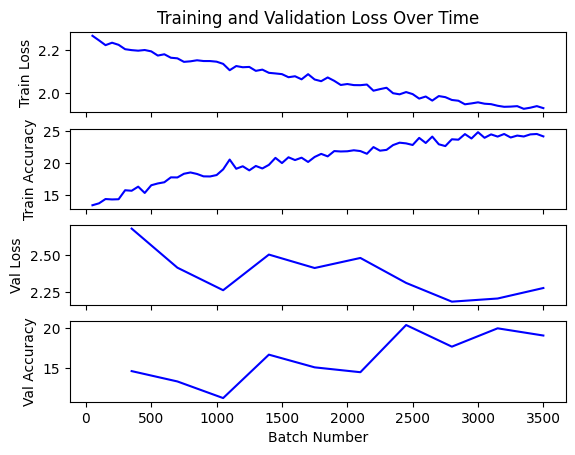

Epoch 11
Batch50, Loss: 1.899, Accuracy: 25.9%
Batch100, Loss: 1.908, Accuracy: 24.6%
Batch150, Loss: 1.911, Accuracy: 24.8%
Batch200, Loss: 1.910, Accuracy: 24.9%
Batch250, Loss: 1.900, Accuracy: 25.3%
Batch300, Loss: 1.919, Accuracy: 24.5%
Batch350, Loss: 1.903, Accuracy: 24.7%
Val Loss: 2.229, Val Accuracy: 20.3%
*****************************************



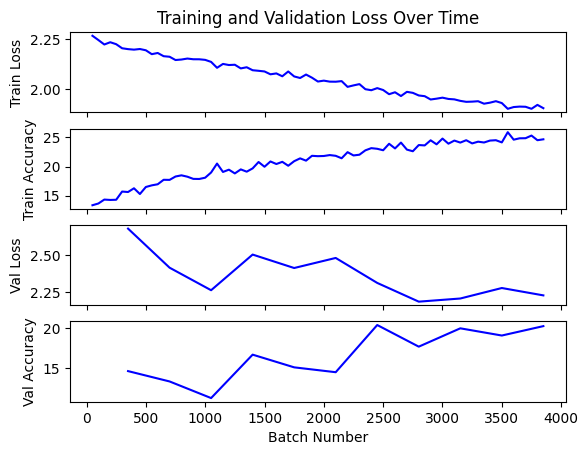

Epoch 12
Batch50, Loss: 1.904, Accuracy: 25.2%
Batch100, Loss: 1.895, Accuracy: 24.8%
Batch150, Loss: 1.901, Accuracy: 24.2%
Batch200, Loss: 1.885, Accuracy: 25.4%
Batch250, Loss: 1.886, Accuracy: 25.6%
Batch300, Loss: 1.907, Accuracy: 25.0%
Batch350, Loss: 1.893, Accuracy: 25.9%
Val Loss: 2.159, Val Accuracy: 20.2%
*****************************************



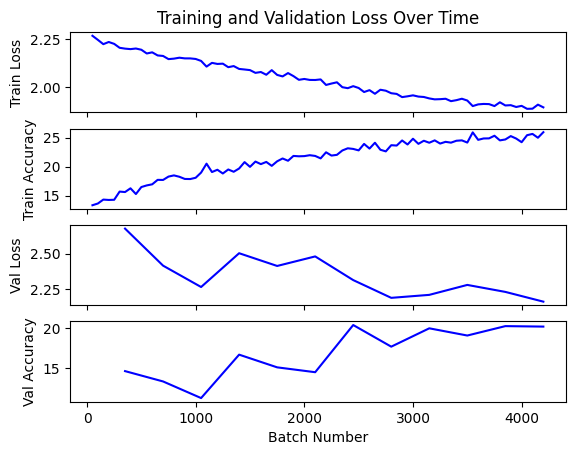

Epoch 13
Batch50, Loss: 1.894, Accuracy: 24.3%
Batch100, Loss: 1.882, Accuracy: 25.1%
Batch150, Loss: 1.846, Accuracy: 26.9%
Batch200, Loss: 1.905, Accuracy: 24.7%
Batch250, Loss: 1.896, Accuracy: 24.8%
Batch300, Loss: 1.879, Accuracy: 25.8%
Batch350, Loss: 1.874, Accuracy: 26.0%
Val Loss: 2.260, Val Accuracy: 22.4%
*****************************************



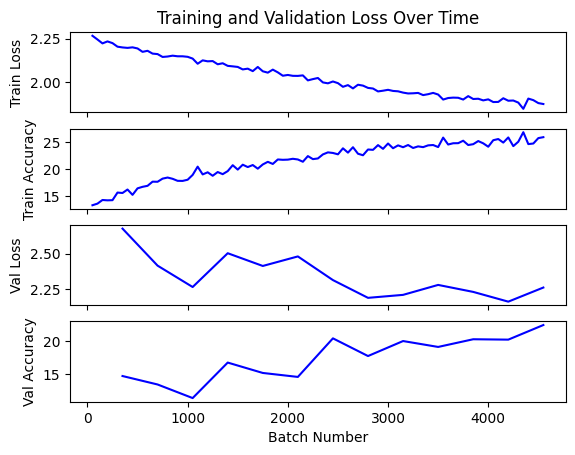

Epoch 14
Batch50, Loss: 1.867, Accuracy: 25.7%
Batch100, Loss: 1.857, Accuracy: 26.2%
Batch150, Loss: 1.885, Accuracy: 24.9%
Batch200, Loss: 1.893, Accuracy: 25.0%
Batch250, Loss: 1.865, Accuracy: 25.9%
Batch300, Loss: 1.838, Accuracy: 26.5%
Batch350, Loss: 1.877, Accuracy: 25.4%
Val Loss: 2.210, Val Accuracy: 19.1%
*****************************************



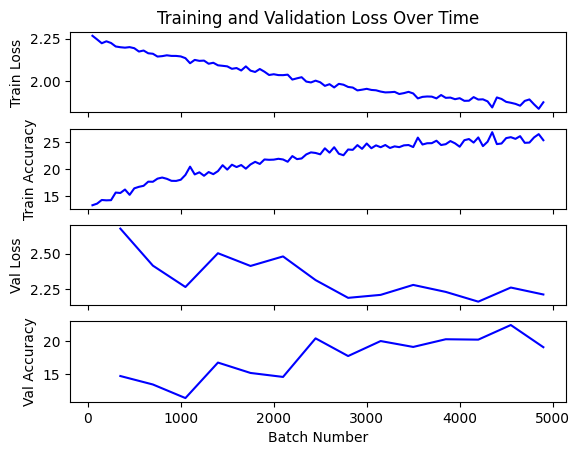

Epoch 15
Batch50, Loss: 1.862, Accuracy: 25.3%
Batch100, Loss: 1.864, Accuracy: 25.3%
Batch150, Loss: 1.820, Accuracy: 27.1%
Batch200, Loss: 1.870, Accuracy: 25.5%
Batch250, Loss: 1.859, Accuracy: 25.7%
Batch300, Loss: 1.868, Accuracy: 25.6%
Batch350, Loss: 1.870, Accuracy: 25.3%
Val Loss: 2.175, Val Accuracy: 22.0%
*****************************************



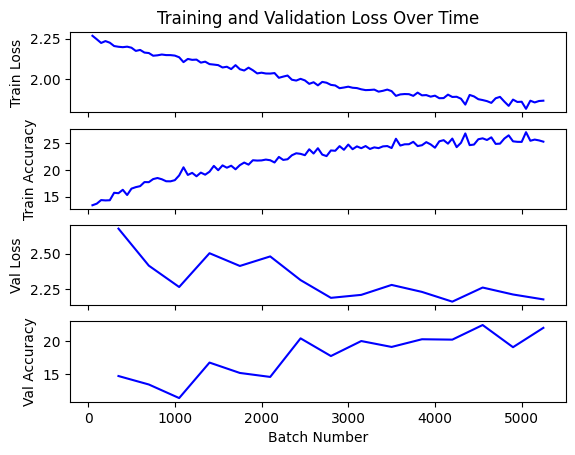

Epoch 16
Batch50, Loss: 1.841, Accuracy: 26.2%
Batch100, Loss: 1.851, Accuracy: 26.1%
Batch150, Loss: 1.830, Accuracy: 26.3%
Batch200, Loss: 1.827, Accuracy: 26.8%
Batch250, Loss: 1.849, Accuracy: 26.2%
Batch300, Loss: 1.872, Accuracy: 24.9%
Batch350, Loss: 1.851, Accuracy: 25.9%
Val Loss: 2.120, Val Accuracy: 19.2%
*****************************************



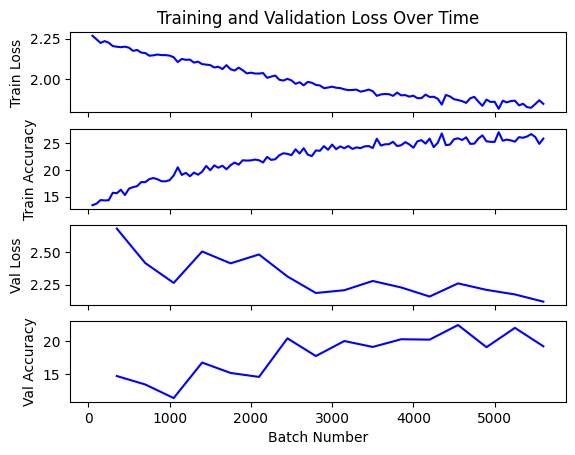

Epoch 17
Batch50, Loss: 1.847, Accuracy: 26.0%
Batch100, Loss: 1.842, Accuracy: 25.8%
Batch150, Loss: 1.836, Accuracy: 26.4%
Batch200, Loss: 1.852, Accuracy: 25.4%
Batch250, Loss: 1.839, Accuracy: 25.9%
Batch300, Loss: 1.828, Accuracy: 26.9%
Batch350, Loss: 1.829, Accuracy: 26.3%
Val Loss: 2.083, Val Accuracy: 19.5%
*****************************************



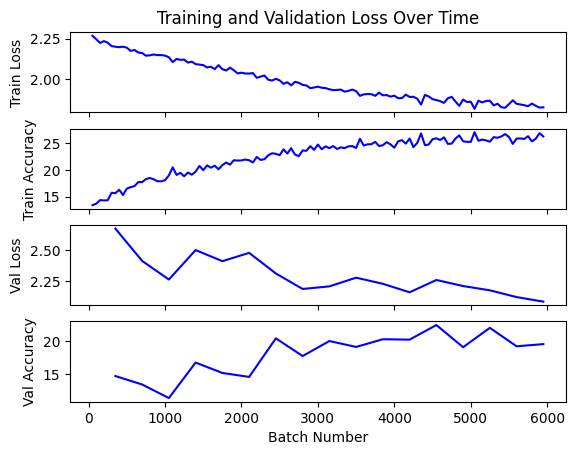

Epoch 18
Batch50, Loss: 1.819, Accuracy: 26.6%
Batch100, Loss: 1.817, Accuracy: 26.7%
Batch150, Loss: 1.849, Accuracy: 26.0%
Batch200, Loss: 1.823, Accuracy: 27.1%
Batch250, Loss: 1.850, Accuracy: 25.9%
Batch300, Loss: 1.849, Accuracy: 25.4%
Batch350, Loss: 1.824, Accuracy: 26.9%
Val Loss: 2.123, Val Accuracy: 20.7%
*****************************************



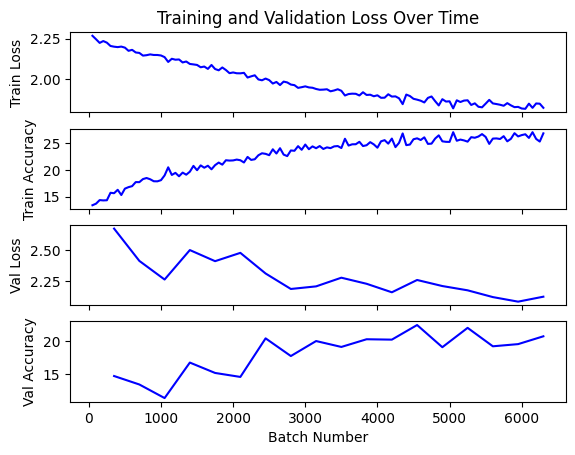

Epoch 19
Batch50, Loss: 1.803, Accuracy: 27.4%
Batch100, Loss: 1.801, Accuracy: 27.1%
Batch150, Loss: 1.839, Accuracy: 25.7%
Batch200, Loss: 1.817, Accuracy: 26.7%
Batch250, Loss: 1.826, Accuracy: 26.4%
Batch300, Loss: 1.832, Accuracy: 26.1%
Batch350, Loss: 1.809, Accuracy: 26.9%
Val Loss: 2.073, Val Accuracy: 20.0%
*****************************************



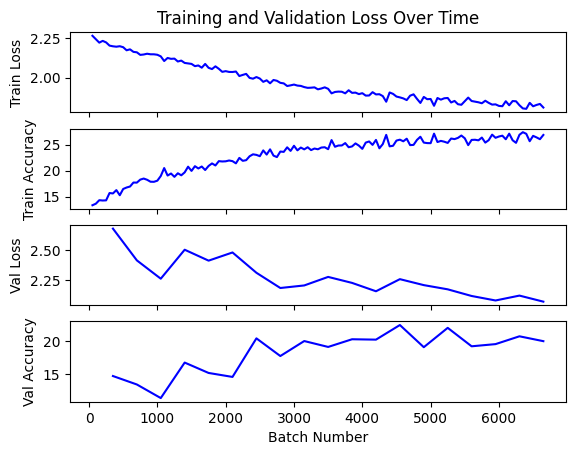

Epoch 20
Batch50, Loss: 1.821, Accuracy: 26.1%
Batch100, Loss: 1.817, Accuracy: 26.4%
Batch150, Loss: 1.810, Accuracy: 27.4%
Batch200, Loss: 1.803, Accuracy: 27.0%
Batch250, Loss: 1.806, Accuracy: 26.8%
Batch300, Loss: 1.810, Accuracy: 26.8%
Batch350, Loss: 1.816, Accuracy: 26.1%
Val Loss: 2.080, Val Accuracy: 19.4%
*****************************************



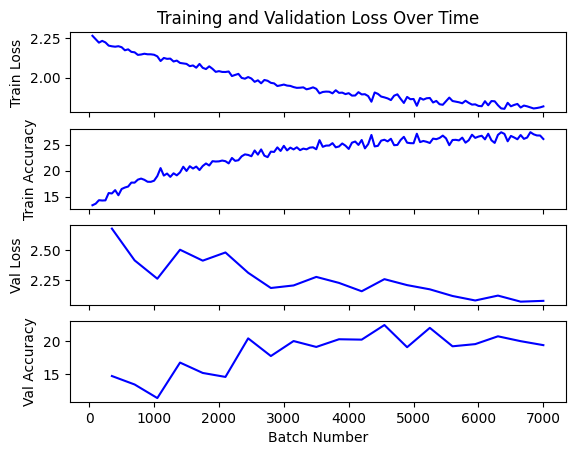

Epoch 21
Batch50, Loss: 1.789, Accuracy: 27.2%
Batch100, Loss: 1.816, Accuracy: 26.5%
Batch150, Loss: 1.801, Accuracy: 26.7%
Batch200, Loss: 1.799, Accuracy: 26.9%
Batch250, Loss: 1.811, Accuracy: 26.3%
Batch300, Loss: 1.796, Accuracy: 27.2%
Batch350, Loss: 1.817, Accuracy: 26.6%
Val Loss: 2.251, Val Accuracy: 18.0%
*****************************************



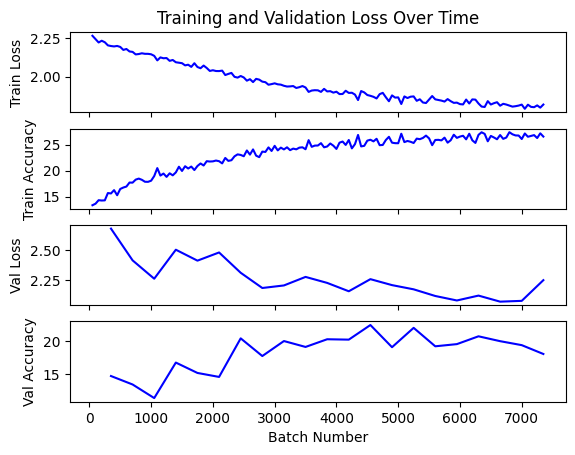

Epoch 22
Batch50, Loss: 1.814, Accuracy: 26.6%
Batch100, Loss: 1.794, Accuracy: 26.7%
Batch150, Loss: 1.800, Accuracy: 26.8%
Batch200, Loss: 1.819, Accuracy: 25.8%
Batch250, Loss: 1.805, Accuracy: 26.7%
Batch300, Loss: 1.804, Accuracy: 26.6%
Batch350, Loss: 1.793, Accuracy: 27.3%
Val Loss: 2.138, Val Accuracy: 21.5%
*****************************************



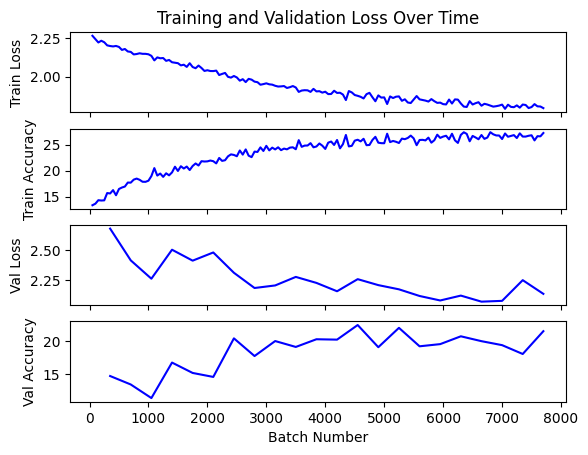

Epoch 23
Batch50, Loss: 1.780, Accuracy: 27.4%
Batch100, Loss: 1.806, Accuracy: 26.7%
Batch150, Loss: 1.802, Accuracy: 26.8%
Batch200, Loss: 1.801, Accuracy: 26.9%
Batch250, Loss: 1.787, Accuracy: 27.5%
Batch300, Loss: 1.812, Accuracy: 26.5%
Batch350, Loss: 1.797, Accuracy: 27.0%
Val Loss: 1.999, Val Accuracy: 23.0%
*****************************************



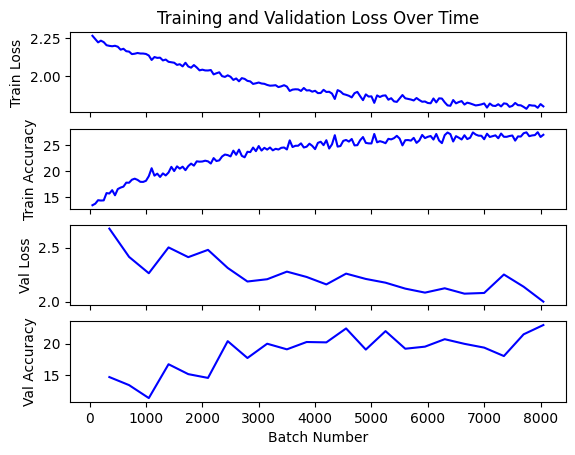

Epoch 24
Batch50, Loss: 1.804, Accuracy: 26.2%
Batch100, Loss: 1.766, Accuracy: 28.1%
Batch150, Loss: 1.775, Accuracy: 27.7%
Batch200, Loss: 1.787, Accuracy: 27.2%
Batch250, Loss: 1.775, Accuracy: 27.5%
Batch300, Loss: 1.798, Accuracy: 26.3%
Batch350, Loss: 1.800, Accuracy: 27.2%
Val Loss: 2.109, Val Accuracy: 20.6%
*****************************************



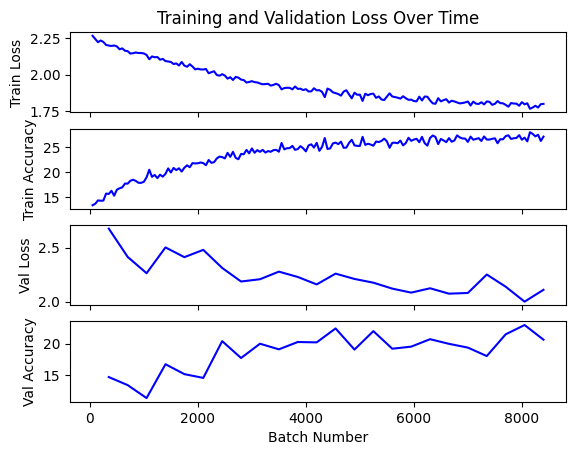

Epoch 25
Batch50, Loss: 1.788, Accuracy: 26.9%
Batch100, Loss: 1.781, Accuracy: 27.4%
Batch150, Loss: 1.798, Accuracy: 26.7%
Batch200, Loss: 1.764, Accuracy: 28.1%
Batch250, Loss: 1.790, Accuracy: 27.5%
Batch300, Loss: 1.773, Accuracy: 27.8%
Batch350, Loss: 1.798, Accuracy: 26.2%
Val Loss: 2.031, Val Accuracy: 20.5%
*****************************************



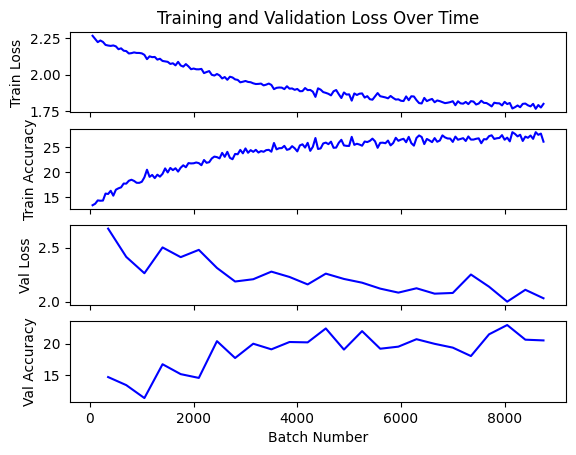

Epoch 26
Batch50, Loss: 1.775, Accuracy: 27.3%
Batch100, Loss: 1.798, Accuracy: 26.2%
Batch150, Loss: 1.787, Accuracy: 26.8%
Batch200, Loss: 1.782, Accuracy: 27.5%
Batch250, Loss: 1.775, Accuracy: 27.9%
Batch300, Loss: 1.754, Accuracy: 28.0%
Batch350, Loss: 1.794, Accuracy: 26.4%
Val Loss: 2.032, Val Accuracy: 21.2%
*****************************************



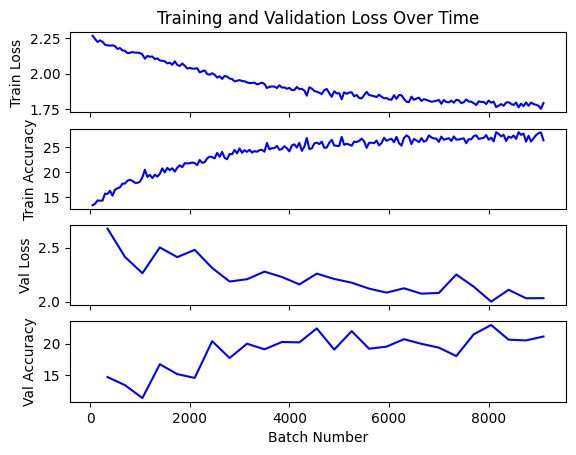

Epoch 27
Batch50, Loss: 1.766, Accuracy: 27.5%
Batch100, Loss: 1.790, Accuracy: 26.8%
Batch150, Loss: 1.777, Accuracy: 27.5%
Batch200, Loss: 1.791, Accuracy: 26.5%
Batch250, Loss: 1.767, Accuracy: 27.8%
Batch300, Loss: 1.774, Accuracy: 27.5%
Batch350, Loss: 1.756, Accuracy: 27.7%
Val Loss: 2.222, Val Accuracy: 21.2%
*****************************************



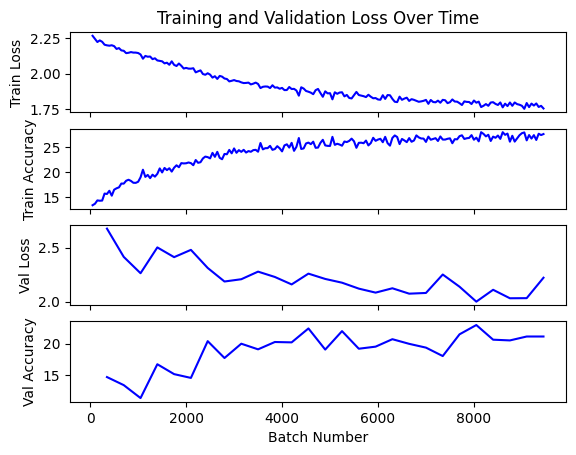

Epoch 28
Batch50, Loss: 1.768, Accuracy: 27.4%
Batch100, Loss: 1.748, Accuracy: 28.3%
Batch150, Loss: 1.774, Accuracy: 27.3%
Batch200, Loss: 1.765, Accuracy: 27.4%
Batch250, Loss: 1.789, Accuracy: 26.4%
Batch300, Loss: 1.764, Accuracy: 27.6%
Batch350, Loss: 1.782, Accuracy: 26.5%
Val Loss: 2.108, Val Accuracy: 22.3%
*****************************************



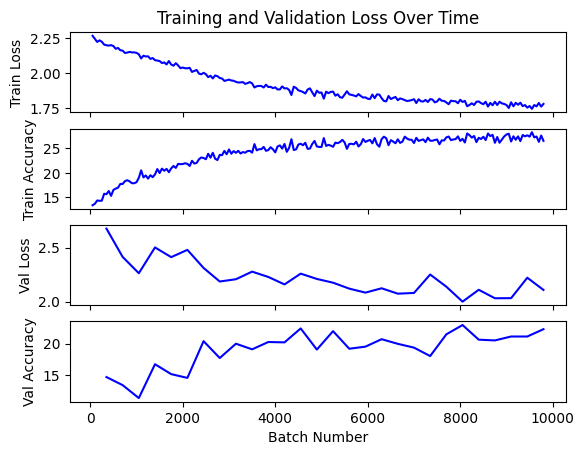

Epoch 29
Batch50, Loss: 1.761, Accuracy: 27.5%
Batch100, Loss: 1.763, Accuracy: 27.4%
Batch150, Loss: 1.768, Accuracy: 27.3%
Batch200, Loss: 1.770, Accuracy: 27.4%
Batch250, Loss: 1.758, Accuracy: 27.5%
Batch300, Loss: 1.776, Accuracy: 27.2%
Batch350, Loss: 1.757, Accuracy: 27.8%
Val Loss: 2.095, Val Accuracy: 22.2%
*****************************************



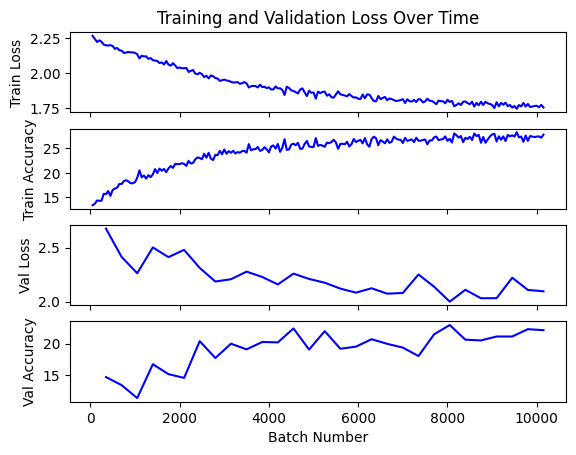

Epoch 30
Batch50, Loss: 1.771, Accuracy: 27.2%
Batch100, Loss: 1.749, Accuracy: 28.4%
Batch150, Loss: 1.761, Accuracy: 27.4%
Batch200, Loss: 1.748, Accuracy: 28.0%
Batch250, Loss: 1.775, Accuracy: 26.8%
Batch300, Loss: 1.776, Accuracy: 27.0%
Batch350, Loss: 1.768, Accuracy: 27.7%
Val Loss: 2.171, Val Accuracy: 17.9%
*****************************************



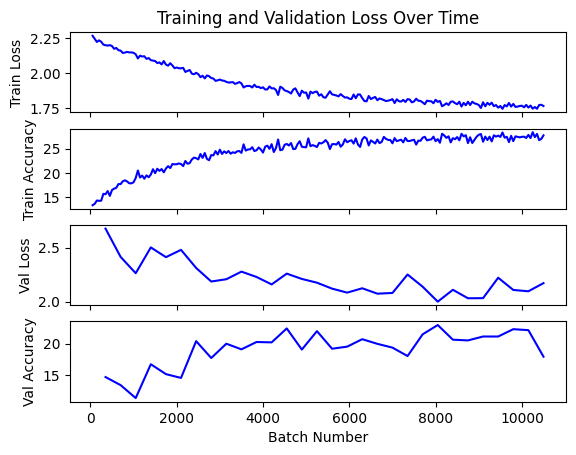

Epoch 31
Batch50, Loss: 1.765, Accuracy: 27.0%
Batch100, Loss: 1.747, Accuracy: 27.8%
Batch150, Loss: 1.751, Accuracy: 27.9%
Batch200, Loss: 1.750, Accuracy: 28.1%
Batch250, Loss: 1.759, Accuracy: 27.5%
Batch300, Loss: 1.762, Accuracy: 27.5%
Batch350, Loss: 1.776, Accuracy: 27.0%
Val Loss: 2.065, Val Accuracy: 17.8%
*****************************************



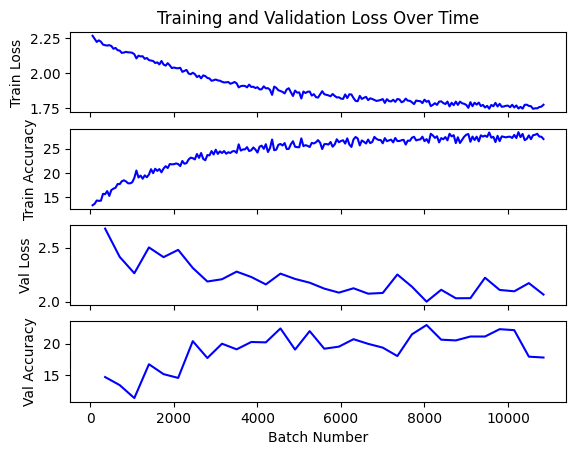

Epoch 32
Batch50, Loss: 1.739, Accuracy: 28.1%
Batch100, Loss: 1.730, Accuracy: 28.4%
Batch150, Loss: 1.763, Accuracy: 26.8%
Batch200, Loss: 1.739, Accuracy: 28.2%
Batch250, Loss: 1.770, Accuracy: 26.8%
Batch300, Loss: 1.766, Accuracy: 26.8%
Batch350, Loss: 1.761, Accuracy: 27.6%
Val Loss: 2.079, Val Accuracy: 19.2%
*****************************************



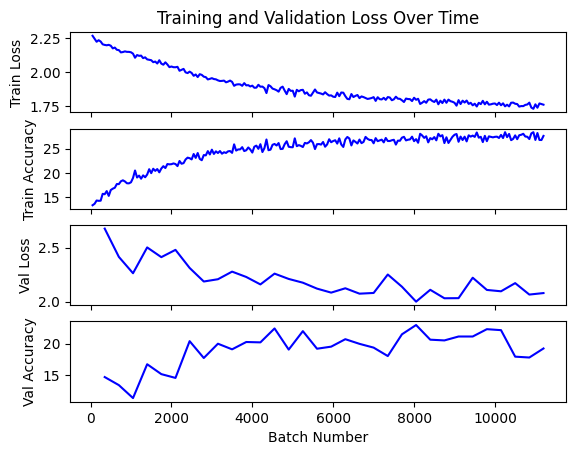

Epoch 33
Batch50, Loss: 1.747, Accuracy: 27.8%
Batch100, Loss: 1.771, Accuracy: 27.0%
Batch150, Loss: 1.735, Accuracy: 28.1%
Batch200, Loss: 1.754, Accuracy: 27.6%
Batch250, Loss: 1.758, Accuracy: 27.3%
Batch300, Loss: 1.747, Accuracy: 27.8%
Batch350, Loss: 1.763, Accuracy: 27.4%
Val Loss: 2.090, Val Accuracy: 20.7%
*****************************************



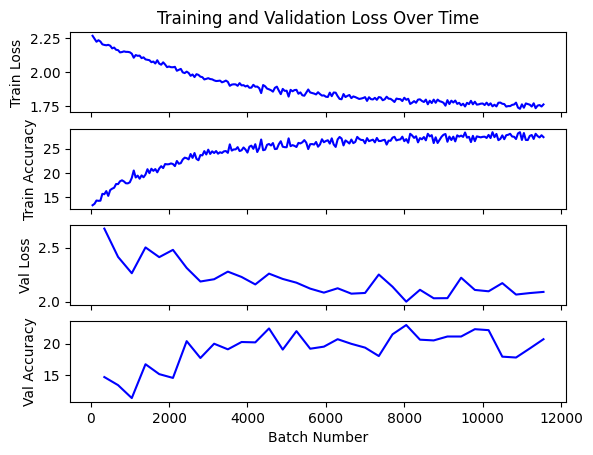

Epoch 34
Batch50, Loss: 1.760, Accuracy: 26.8%
Batch100, Loss: 1.756, Accuracy: 27.3%
Batch150, Loss: 1.747, Accuracy: 27.9%
Batch200, Loss: 1.750, Accuracy: 28.0%
Batch250, Loss: 1.737, Accuracy: 28.2%
Batch300, Loss: 1.738, Accuracy: 28.2%
Batch350, Loss: 1.760, Accuracy: 28.1%
Val Loss: 2.081, Val Accuracy: 16.8%
*****************************************



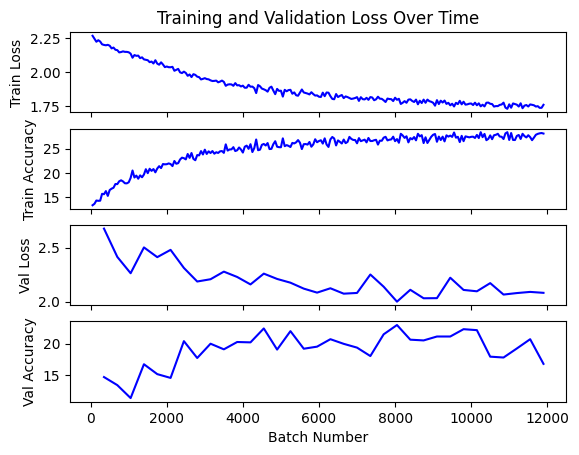

Epoch 35
Batch50, Loss: 1.750, Accuracy: 27.4%
Batch100, Loss: 1.738, Accuracy: 28.5%
Batch150, Loss: 1.779, Accuracy: 26.8%
Batch200, Loss: 1.740, Accuracy: 28.0%
Batch250, Loss: 1.748, Accuracy: 27.6%
Batch300, Loss: 1.740, Accuracy: 27.9%
Batch350, Loss: 1.739, Accuracy: 28.3%
Val Loss: 2.043, Val Accuracy: 20.7%
*****************************************



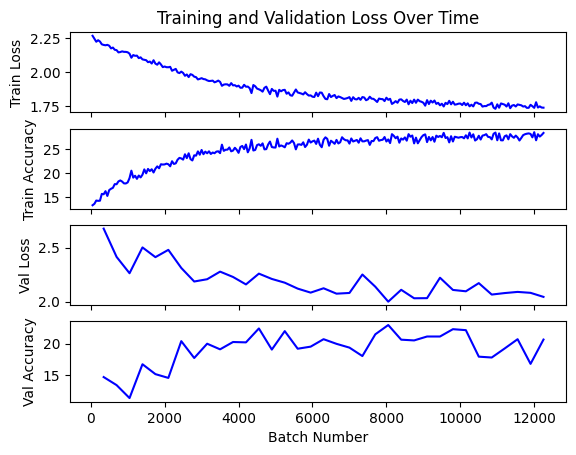

Epoch 36
Batch50, Loss: 1.745, Accuracy: 27.2%
Batch100, Loss: 1.734, Accuracy: 28.2%
Batch150, Loss: 1.748, Accuracy: 27.9%
Batch200, Loss: 1.752, Accuracy: 27.5%
Batch250, Loss: 1.734, Accuracy: 28.0%
Batch300, Loss: 1.734, Accuracy: 27.8%
Batch350, Loss: 1.737, Accuracy: 28.4%
Val Loss: 2.057, Val Accuracy: 23.3%
*****************************************



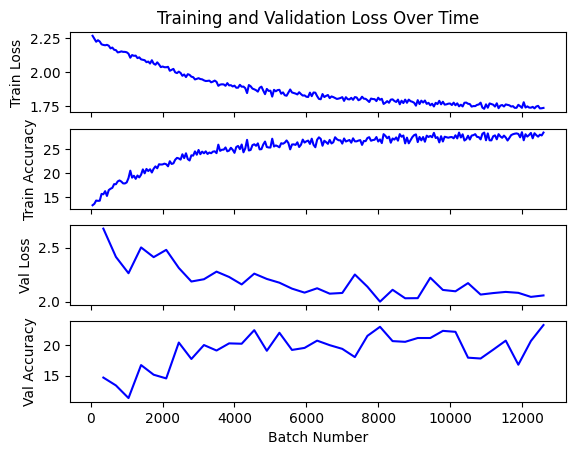

Epoch 37
Batch50, Loss: 1.744, Accuracy: 27.3%
Batch100, Loss: 1.737, Accuracy: 28.3%
Batch150, Loss: 1.728, Accuracy: 28.1%
Batch200, Loss: 1.729, Accuracy: 28.6%
Batch250, Loss: 1.759, Accuracy: 27.2%
Batch300, Loss: 1.755, Accuracy: 27.4%
Batch350, Loss: 1.747, Accuracy: 27.5%
Val Loss: 2.106, Val Accuracy: 17.0%
*****************************************



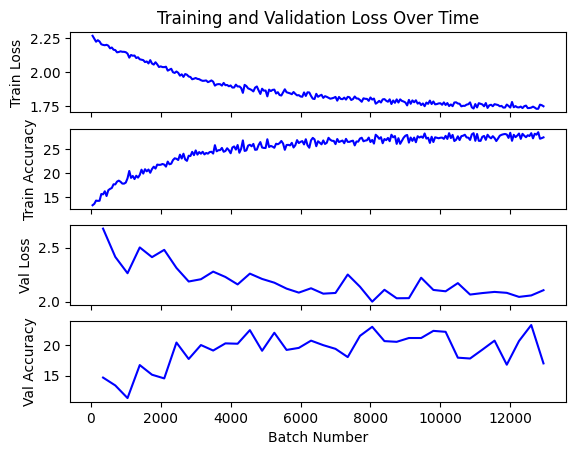

Epoch 38
Batch50, Loss: 1.741, Accuracy: 27.8%
Batch100, Loss: 1.731, Accuracy: 28.3%
Batch150, Loss: 1.729, Accuracy: 28.2%
Batch200, Loss: 1.737, Accuracy: 27.7%
Batch250, Loss: 1.733, Accuracy: 28.3%
Batch300, Loss: 1.727, Accuracy: 28.3%
Batch350, Loss: 1.760, Accuracy: 26.7%
Val Loss: 2.092, Val Accuracy: 22.4%
*****************************************



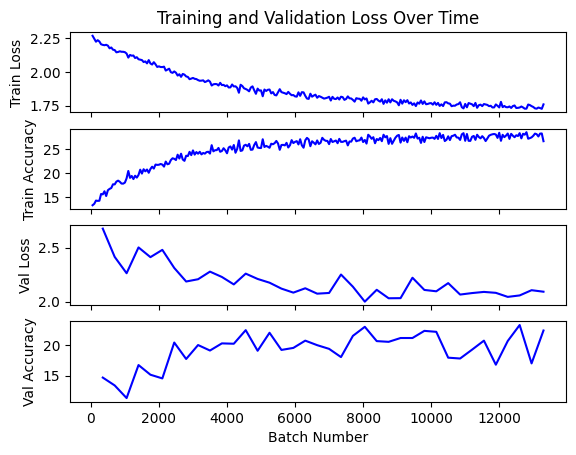

Epoch 39
Batch50, Loss: 1.713, Accuracy: 28.6%
Batch100, Loss: 1.751, Accuracy: 27.0%
Batch150, Loss: 1.740, Accuracy: 28.1%
Batch200, Loss: 1.739, Accuracy: 27.9%
Batch250, Loss: 1.721, Accuracy: 28.6%
Batch300, Loss: 1.749, Accuracy: 27.2%
Batch350, Loss: 1.725, Accuracy: 28.3%
Val Loss: 2.254, Val Accuracy: 19.5%
*****************************************



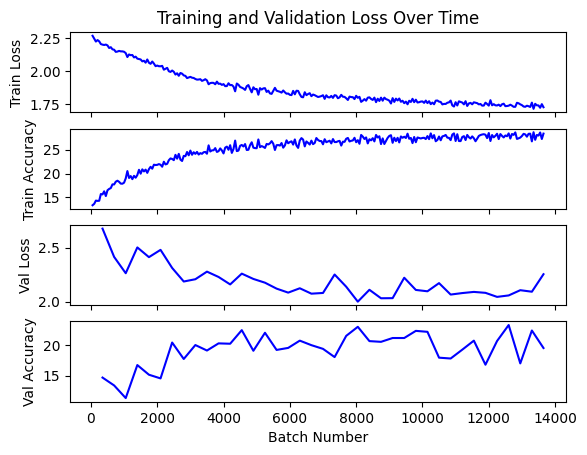

Epoch 40
Batch50, Loss: 1.740, Accuracy: 27.7%
Batch100, Loss: 1.720, Accuracy: 28.5%
Batch150, Loss: 1.733, Accuracy: 27.8%
Batch200, Loss: 1.718, Accuracy: 28.6%
Batch250, Loss: 1.737, Accuracy: 27.8%
Batch300, Loss: 1.738, Accuracy: 28.0%
Batch350, Loss: 1.760, Accuracy: 27.4%
Val Loss: 2.055, Val Accuracy: 18.5%
*****************************************



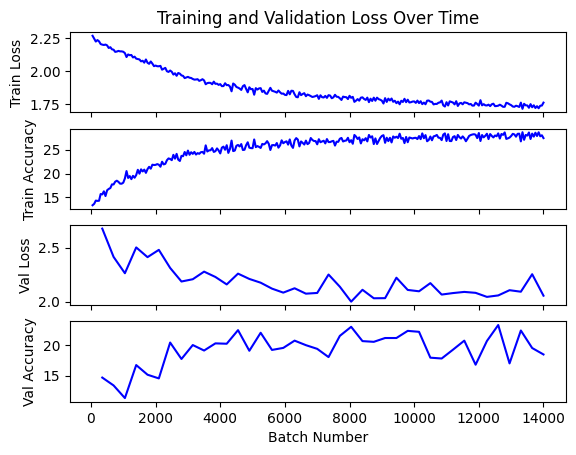

Epoch 41
Batch50, Loss: 1.723, Accuracy: 28.2%
Batch100, Loss: 1.687, Accuracy: 29.6%
Batch150, Loss: 1.732, Accuracy: 28.0%
Batch200, Loss: 1.739, Accuracy: 27.9%
Batch250, Loss: 1.740, Accuracy: 27.4%
Batch300, Loss: 1.742, Accuracy: 27.4%
Batch350, Loss: 1.737, Accuracy: 27.5%
Val Loss: 2.043, Val Accuracy: 20.1%
*****************************************



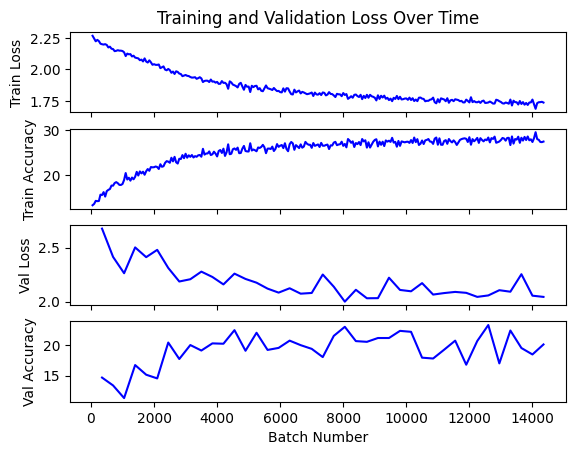

Epoch 42
Batch50, Loss: 1.700, Accuracy: 29.0%
Batch100, Loss: 1.717, Accuracy: 28.3%
Batch150, Loss: 1.726, Accuracy: 28.4%
Batch200, Loss: 1.737, Accuracy: 28.0%
Batch250, Loss: 1.740, Accuracy: 27.5%
Batch300, Loss: 1.748, Accuracy: 27.5%
Batch350, Loss: 1.730, Accuracy: 28.3%
Val Loss: 2.086, Val Accuracy: 20.0%
*****************************************



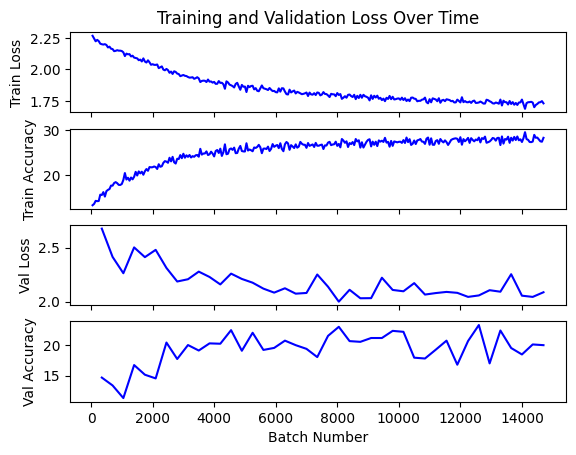

Epoch 43
Batch50, Loss: 1.689, Accuracy: 29.5%
Batch100, Loss: 1.719, Accuracy: 28.2%
Batch150, Loss: 1.753, Accuracy: 26.9%
Batch200, Loss: 1.702, Accuracy: 29.2%
Batch250, Loss: 1.713, Accuracy: 28.4%
Batch300, Loss: 1.740, Accuracy: 27.5%
Batch350, Loss: 1.749, Accuracy: 27.3%
Val Loss: 2.127, Val Accuracy: 22.4%
*****************************************



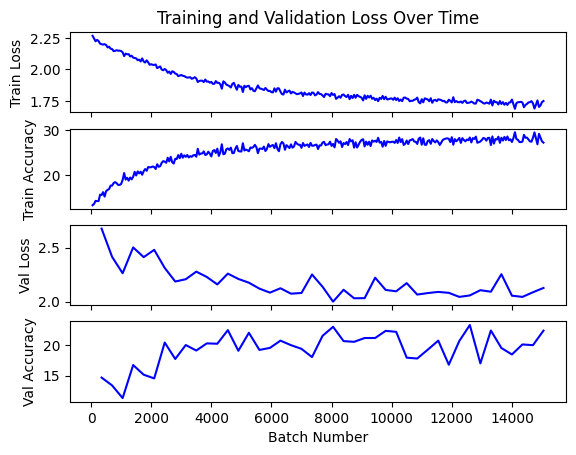

Epoch 44
Batch50, Loss: 1.738, Accuracy: 27.6%
Batch100, Loss: 1.721, Accuracy: 27.9%
Batch150, Loss: 1.698, Accuracy: 29.0%
Batch200, Loss: 1.720, Accuracy: 28.3%
Batch250, Loss: 1.737, Accuracy: 27.3%
Batch300, Loss: 1.718, Accuracy: 28.4%
Batch350, Loss: 1.713, Accuracy: 28.7%
Val Loss: 2.049, Val Accuracy: 20.1%
*****************************************



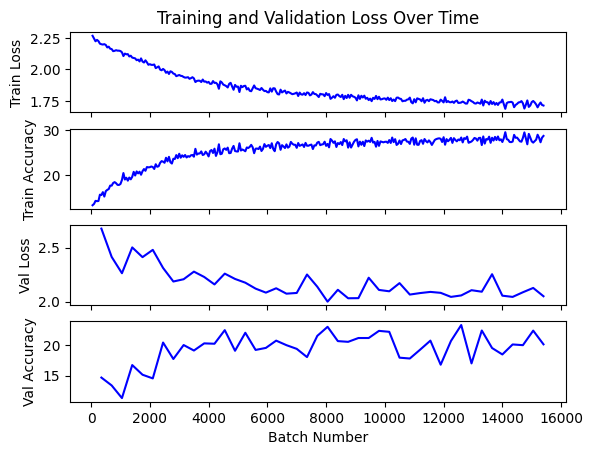

Epoch 45
Batch50, Loss: 1.723, Accuracy: 28.2%
Batch100, Loss: 1.709, Accuracy: 28.5%
Batch150, Loss: 1.706, Accuracy: 28.5%
Batch200, Loss: 1.728, Accuracy: 27.8%
Batch250, Loss: 1.733, Accuracy: 27.5%
Batch300, Loss: 1.706, Accuracy: 29.1%
Batch350, Loss: 1.735, Accuracy: 27.6%
Val Loss: 2.130, Val Accuracy: 18.3%
*****************************************



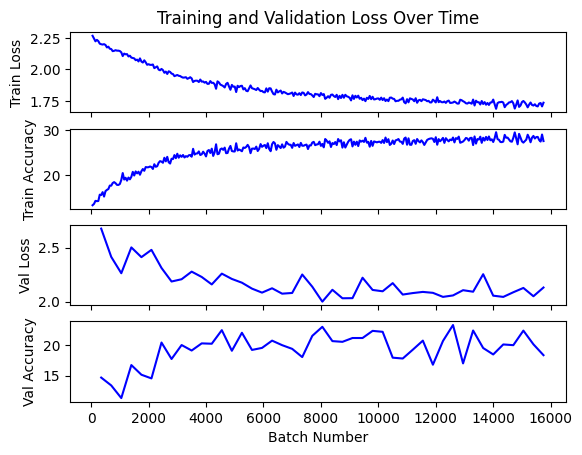

Epoch 46
Batch50, Loss: 1.710, Accuracy: 28.6%
Batch100, Loss: 1.713, Accuracy: 28.3%
Batch150, Loss: 1.718, Accuracy: 28.4%
Batch200, Loss: 1.749, Accuracy: 27.0%
Batch250, Loss: 1.709, Accuracy: 28.9%
Batch300, Loss: 1.723, Accuracy: 28.0%
Batch350, Loss: 1.712, Accuracy: 28.5%
Val Loss: 2.095, Val Accuracy: 17.5%
*****************************************



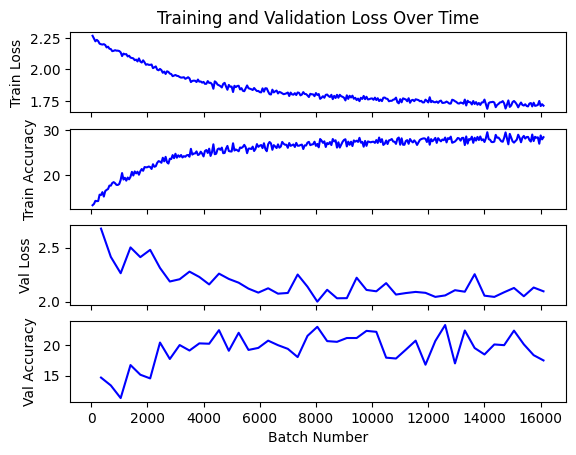

Epoch 47
Batch50, Loss: 1.726, Accuracy: 27.8%
Batch100, Loss: 1.707, Accuracy: 28.8%
Batch150, Loss: 1.712, Accuracy: 28.4%
Batch200, Loss: 1.727, Accuracy: 27.7%
Batch250, Loss: 1.732, Accuracy: 28.1%
Batch300, Loss: 1.701, Accuracy: 29.1%
Batch350, Loss: 1.741, Accuracy: 27.5%
Val Loss: 1.997, Val Accuracy: 22.8%
*****************************************



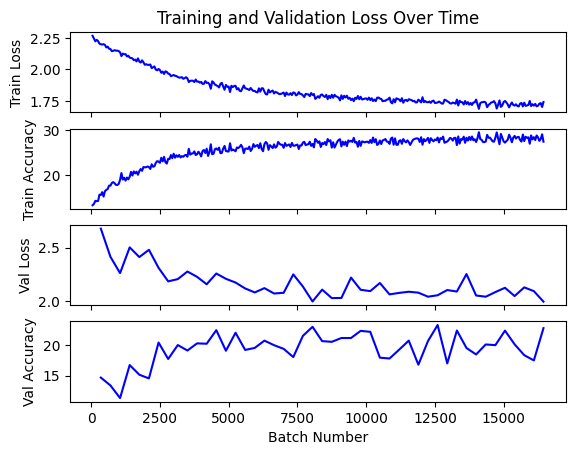

Epoch 48
Batch50, Loss: 1.692, Accuracy: 29.2%
Batch100, Loss: 1.720, Accuracy: 27.9%
Batch150, Loss: 1.719, Accuracy: 27.9%
Batch200, Loss: 1.737, Accuracy: 27.3%
Batch250, Loss: 1.719, Accuracy: 28.7%
Batch300, Loss: 1.711, Accuracy: 28.5%
Batch350, Loss: 1.723, Accuracy: 28.0%
Val Loss: 2.123, Val Accuracy: 15.5%
*****************************************



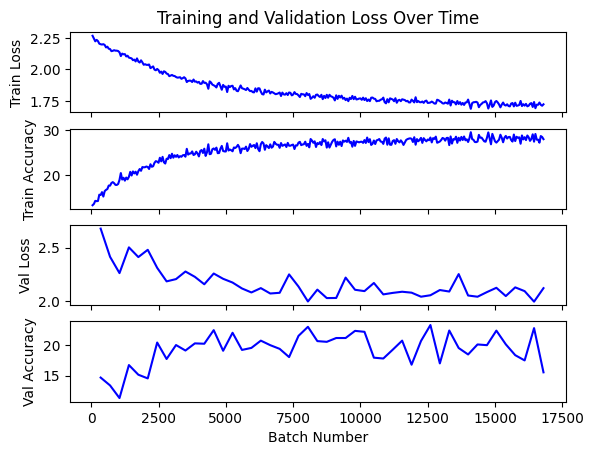

Epoch 49
Batch50, Loss: 1.711, Accuracy: 28.2%
Batch100, Loss: 1.698, Accuracy: 28.8%
Batch150, Loss: 1.704, Accuracy: 28.5%
Batch200, Loss: 1.701, Accuracy: 29.1%
Batch250, Loss: 1.717, Accuracy: 28.2%
Batch300, Loss: 1.730, Accuracy: 27.6%
Batch350, Loss: 1.730, Accuracy: 27.6%
Val Loss: 2.066, Val Accuracy: 19.4%
*****************************************



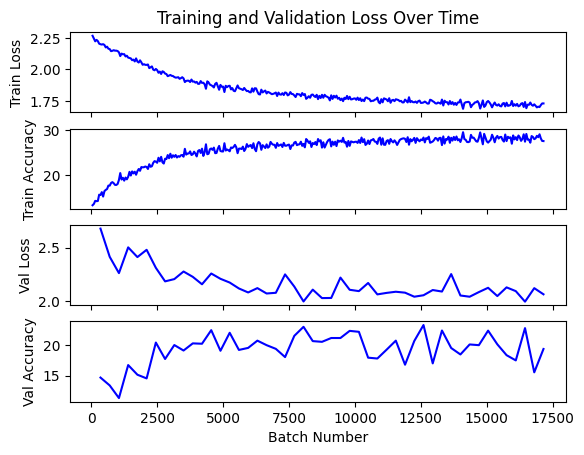

Epoch 50
Batch50, Loss: 1.707, Accuracy: 28.3%
Batch100, Loss: 1.702, Accuracy: 28.7%
Batch150, Loss: 1.702, Accuracy: 28.4%
Batch200, Loss: 1.711, Accuracy: 28.4%
Batch250, Loss: 1.717, Accuracy: 28.2%
Batch300, Loss: 1.711, Accuracy: 28.0%
Batch350, Loss: 1.692, Accuracy: 29.1%
Val Loss: 2.033, Val Accuracy: 20.0%
*****************************************



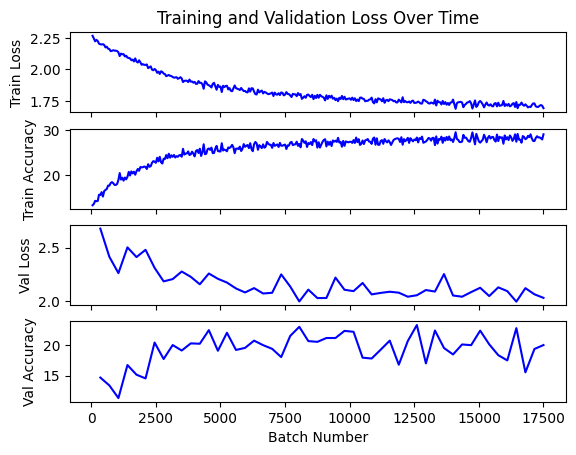

Epoch 51
Batch50, Loss: 1.709, Accuracy: 28.2%
Batch100, Loss: 1.703, Accuracy: 28.9%
Batch150, Loss: 1.689, Accuracy: 29.0%
Batch200, Loss: 1.724, Accuracy: 28.1%
Batch250, Loss: 1.725, Accuracy: 28.1%
Batch300, Loss: 1.727, Accuracy: 27.8%
Batch350, Loss: 1.706, Accuracy: 28.5%
Val Loss: 2.008, Val Accuracy: 20.4%
*****************************************



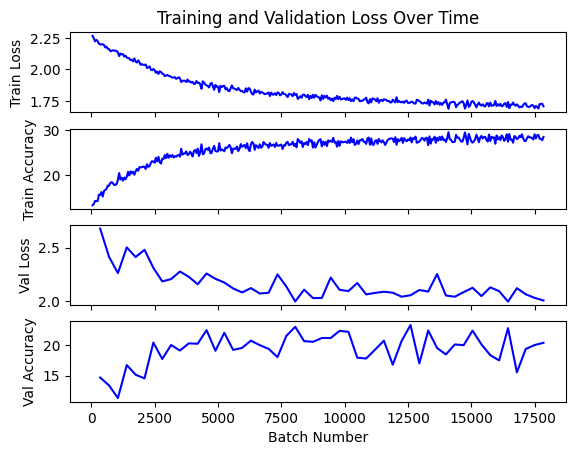

Epoch 52
Batch50, Loss: 1.706, Accuracy: 28.3%
Batch100, Loss: 1.693, Accuracy: 28.9%
Batch150, Loss: 1.696, Accuracy: 28.7%
Batch200, Loss: 1.718, Accuracy: 28.0%
Batch250, Loss: 1.711, Accuracy: 28.5%
Batch300, Loss: 1.710, Accuracy: 28.4%
Batch350, Loss: 1.724, Accuracy: 27.8%
Val Loss: 2.104, Val Accuracy: 16.5%
*****************************************



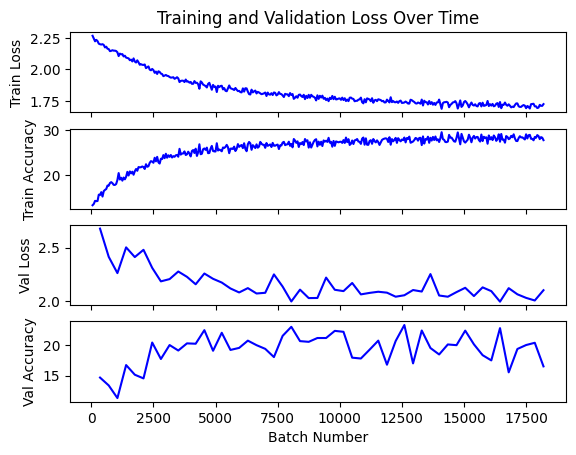

Epoch 53
Batch50, Loss: 1.689, Accuracy: 28.8%
Batch100, Loss: 1.694, Accuracy: 28.7%
Batch150, Loss: 1.704, Accuracy: 28.2%
Batch200, Loss: 1.715, Accuracy: 27.8%
Batch250, Loss: 1.714, Accuracy: 28.2%
Batch300, Loss: 1.700, Accuracy: 28.6%
Batch350, Loss: 1.719, Accuracy: 28.0%
Val Loss: 2.004, Val Accuracy: 22.0%
*****************************************



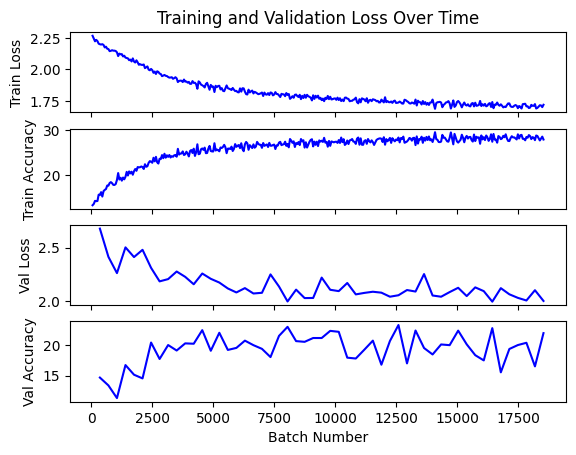

Epoch 54
Batch50, Loss: 1.706, Accuracy: 28.3%
Batch100, Loss: 1.686, Accuracy: 29.2%
Batch150, Loss: 1.703, Accuracy: 28.4%
Batch200, Loss: 1.711, Accuracy: 28.4%
Batch250, Loss: 1.714, Accuracy: 28.3%
Batch300, Loss: 1.718, Accuracy: 28.1%
Batch350, Loss: 1.726, Accuracy: 27.8%
Val Loss: 2.079, Val Accuracy: 21.1%
*****************************************



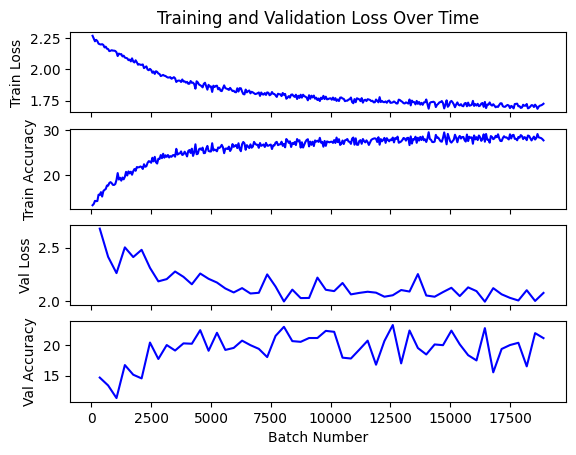

Epoch 55
Batch50, Loss: 1.707, Accuracy: 28.5%
Batch100, Loss: 1.687, Accuracy: 28.9%
Batch150, Loss: 1.697, Accuracy: 28.7%
Batch200, Loss: 1.686, Accuracy: 29.4%
Batch250, Loss: 1.703, Accuracy: 28.3%
Batch300, Loss: 1.718, Accuracy: 27.9%
Batch350, Loss: 1.709, Accuracy: 28.5%
Val Loss: 2.106, Val Accuracy: 17.1%
*****************************************



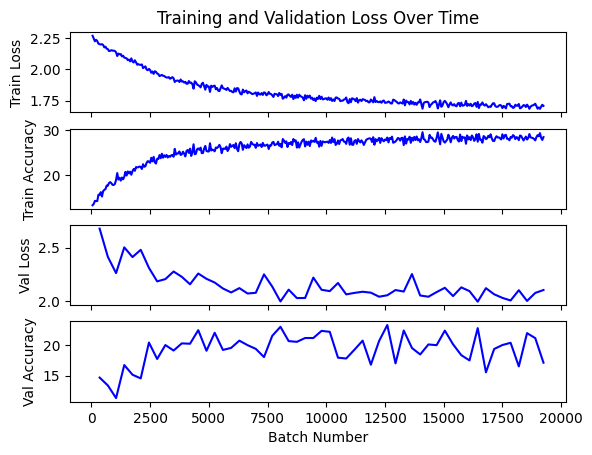

Epoch 56
Batch50, Loss: 1.688, Accuracy: 29.1%
Batch100, Loss: 1.719, Accuracy: 27.3%
Batch150, Loss: 1.695, Accuracy: 28.7%
Batch200, Loss: 1.702, Accuracy: 28.4%
Batch250, Loss: 1.696, Accuracy: 28.4%
Batch300, Loss: 1.710, Accuracy: 28.2%
Batch350, Loss: 1.709, Accuracy: 28.6%
Val Loss: 2.116, Val Accuracy: 17.3%
*****************************************



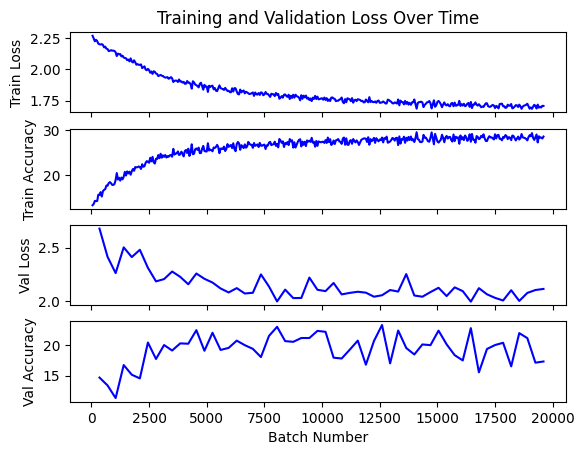

Epoch 57
Batch50, Loss: 1.711, Accuracy: 28.2%
Batch100, Loss: 1.688, Accuracy: 29.0%
Batch150, Loss: 1.683, Accuracy: 29.3%
Batch200, Loss: 1.703, Accuracy: 28.4%
Batch250, Loss: 1.686, Accuracy: 29.1%
Batch300, Loss: 1.723, Accuracy: 27.3%
Batch350, Loss: 1.692, Accuracy: 28.7%
Val Loss: 2.146, Val Accuracy: 14.9%
*****************************************



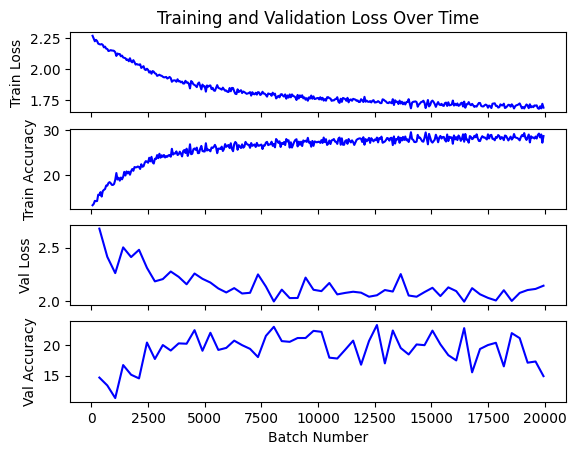

Epoch 58
Batch50, Loss: 1.696, Accuracy: 28.6%
Batch100, Loss: 1.707, Accuracy: 28.3%
Batch150, Loss: 1.694, Accuracy: 28.8%
Batch200, Loss: 1.694, Accuracy: 28.7%
Batch250, Loss: 1.701, Accuracy: 28.4%
Batch300, Loss: 1.704, Accuracy: 28.5%
Batch350, Loss: 1.708, Accuracy: 28.3%
Val Loss: 2.089, Val Accuracy: 18.7%
*****************************************



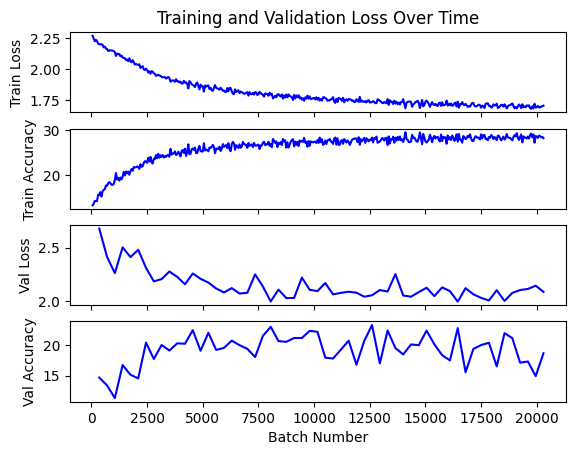

Epoch 59
Batch50, Loss: 1.698, Accuracy: 28.6%
Batch100, Loss: 1.688, Accuracy: 29.3%
Batch150, Loss: 1.686, Accuracy: 29.0%
Batch200, Loss: 1.693, Accuracy: 29.0%
Batch250, Loss: 1.714, Accuracy: 27.7%
Batch300, Loss: 1.698, Accuracy: 28.6%
Batch350, Loss: 1.714, Accuracy: 27.9%
Val Loss: 2.092, Val Accuracy: 18.5%
*****************************************



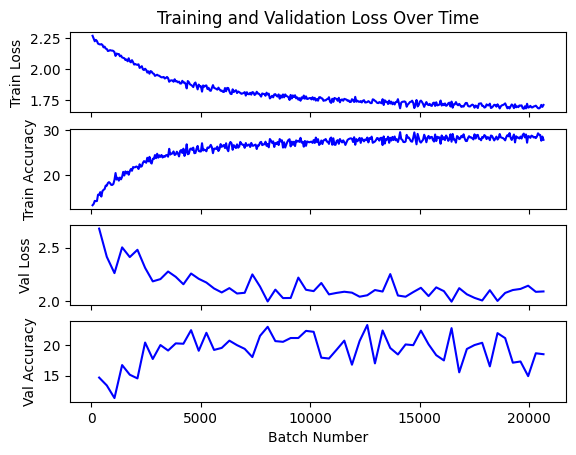

Epoch 60
Batch50, Loss: 1.690, Accuracy: 28.9%
Batch100, Loss: 1.698, Accuracy: 28.4%
Batch150, Loss: 1.705, Accuracy: 27.9%
Batch200, Loss: 1.679, Accuracy: 29.2%
Batch250, Loss: 1.682, Accuracy: 29.2%
Batch300, Loss: 1.710, Accuracy: 28.0%
Batch350, Loss: 1.697, Accuracy: 28.8%
Val Loss: 2.027, Val Accuracy: 19.8%
*****************************************



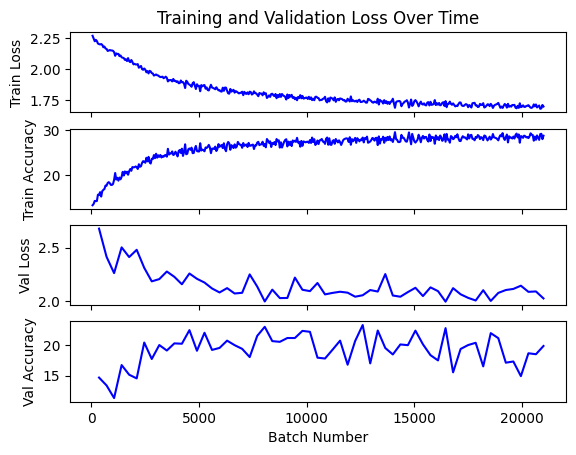

Epoch 61
Batch50, Loss: 1.685, Accuracy: 28.9%
Batch100, Loss: 1.704, Accuracy: 28.2%
Batch150, Loss: 1.695, Accuracy: 28.6%
Batch200, Loss: 1.708, Accuracy: 27.8%
Batch250, Loss: 1.692, Accuracy: 28.9%
Batch300, Loss: 1.688, Accuracy: 29.2%
Batch350, Loss: 1.694, Accuracy: 28.7%
Val Loss: 2.088, Val Accuracy: 17.5%
*****************************************



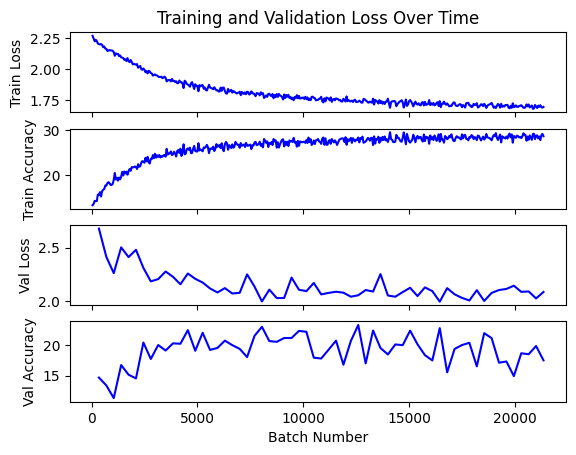

Epoch 62
Batch50, Loss: 1.683, Accuracy: 29.5%
Batch100, Loss: 1.694, Accuracy: 28.6%
Batch150, Loss: 1.696, Accuracy: 28.3%
Batch200, Loss: 1.714, Accuracy: 27.6%
Batch250, Loss: 1.685, Accuracy: 28.7%
Batch300, Loss: 1.679, Accuracy: 29.0%
Batch350, Loss: 1.697, Accuracy: 28.6%
Val Loss: 2.049, Val Accuracy: 19.4%
*****************************************



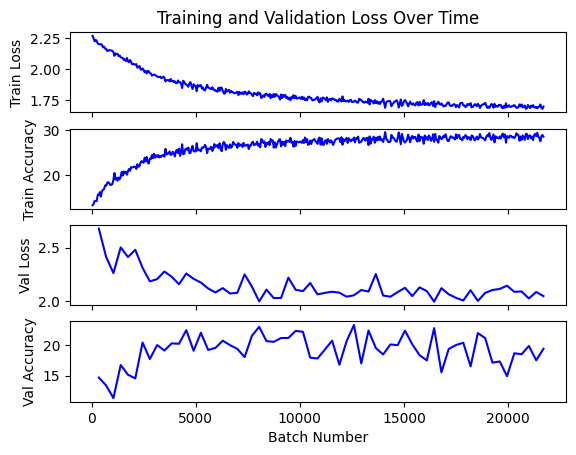

Epoch 63
Batch50, Loss: 1.681, Accuracy: 28.8%
Batch100, Loss: 1.699, Accuracy: 28.5%
Batch150, Loss: 1.708, Accuracy: 27.9%
Batch200, Loss: 1.675, Accuracy: 29.7%
Batch250, Loss: 1.701, Accuracy: 28.3%
Batch300, Loss: 1.707, Accuracy: 28.2%
Batch350, Loss: 1.682, Accuracy: 29.3%
Val Loss: 2.144, Val Accuracy: 18.0%
*****************************************



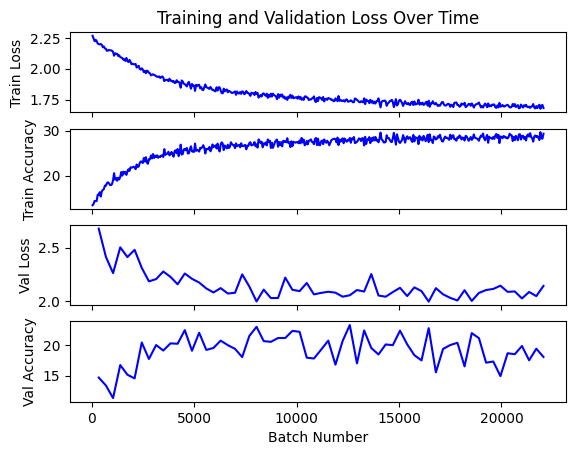

Epoch 64
Batch50, Loss: 1.695, Accuracy: 28.1%
Batch100, Loss: 1.668, Accuracy: 29.1%
Batch150, Loss: 1.684, Accuracy: 29.0%
Batch200, Loss: 1.702, Accuracy: 28.2%
Batch250, Loss: 1.671, Accuracy: 29.5%
Batch300, Loss: 1.701, Accuracy: 28.4%
Batch350, Loss: 1.697, Accuracy: 28.7%
Val Loss: 2.096, Val Accuracy: 17.2%
*****************************************



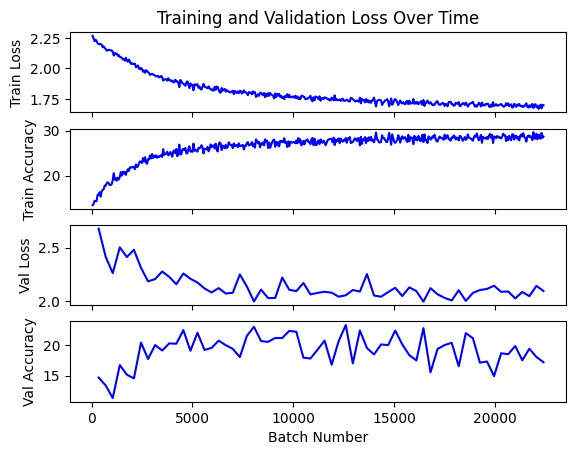

Epoch 65
Batch50, Loss: 1.671, Accuracy: 29.3%
Batch100, Loss: 1.711, Accuracy: 27.7%
Batch150, Loss: 1.674, Accuracy: 29.5%
Batch200, Loss: 1.683, Accuracy: 29.5%
Batch250, Loss: 1.698, Accuracy: 28.3%
Batch300, Loss: 1.690, Accuracy: 29.0%
Batch350, Loss: 1.723, Accuracy: 27.3%
Val Loss: 2.147, Val Accuracy: 14.5%
*****************************************



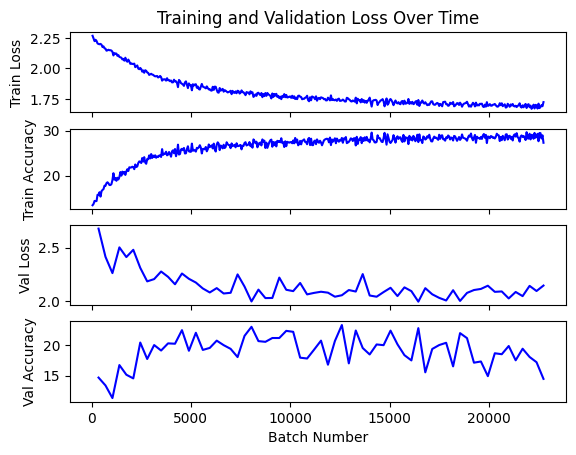

Epoch 66
Batch50, Loss: 1.669, Accuracy: 29.5%
Batch100, Loss: 1.693, Accuracy: 28.4%
Batch150, Loss: 1.701, Accuracy: 28.1%
Batch200, Loss: 1.672, Accuracy: 29.4%
Batch250, Loss: 1.706, Accuracy: 27.9%
Batch300, Loss: 1.682, Accuracy: 29.0%
Batch350, Loss: 1.698, Accuracy: 28.3%
Val Loss: 2.029, Val Accuracy: 19.6%
*****************************************



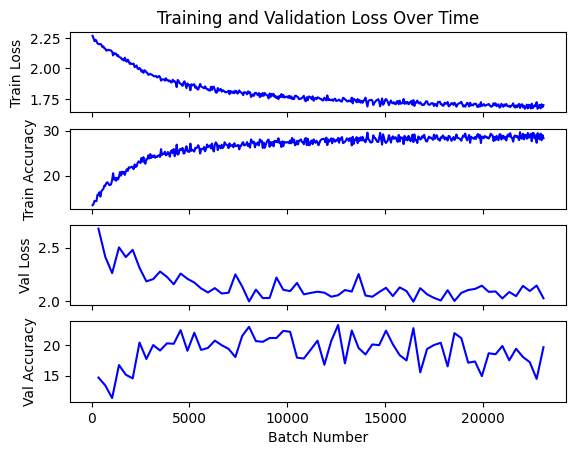

Epoch 67
Batch50, Loss: 1.678, Accuracy: 29.0%
Batch100, Loss: 1.663, Accuracy: 29.9%
Batch150, Loss: 1.703, Accuracy: 27.9%
Batch200, Loss: 1.675, Accuracy: 29.3%
Batch250, Loss: 1.696, Accuracy: 28.6%
Batch300, Loss: 1.688, Accuracy: 28.7%
Batch350, Loss: 1.702, Accuracy: 28.3%
Val Loss: 2.140, Val Accuracy: 15.3%
*****************************************



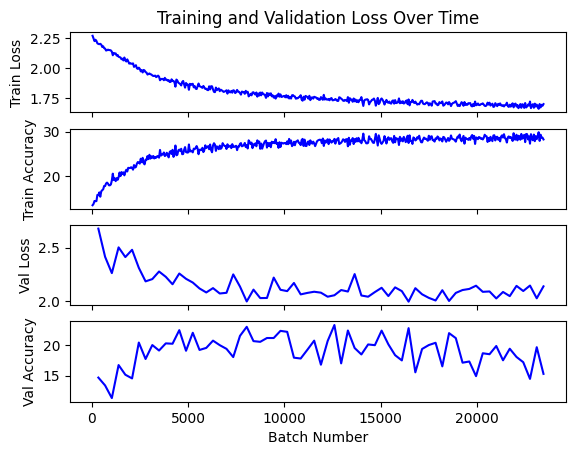

Epoch 68
Batch50, Loss: 1.677, Accuracy: 28.8%
Batch100, Loss: 1.701, Accuracy: 28.1%
Batch150, Loss: 1.679, Accuracy: 28.9%
Batch200, Loss: 1.679, Accuracy: 28.7%
Batch250, Loss: 1.678, Accuracy: 28.9%
Batch300, Loss: 1.678, Accuracy: 28.8%
Batch350, Loss: 1.692, Accuracy: 28.9%
Val Loss: 2.102, Val Accuracy: 15.8%
*****************************************



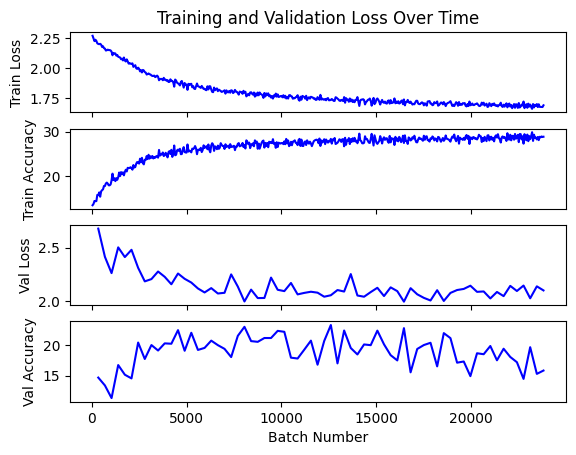

Epoch 69
Batch50, Loss: 1.681, Accuracy: 28.9%
Batch100, Loss: 1.692, Accuracy: 28.5%
Batch150, Loss: 1.669, Accuracy: 29.4%
Batch200, Loss: 1.678, Accuracy: 29.0%
Batch250, Loss: 1.682, Accuracy: 28.8%
Batch300, Loss: 1.697, Accuracy: 28.2%
Batch350, Loss: 1.693, Accuracy: 28.6%
Val Loss: 2.124, Val Accuracy: 14.9%
*****************************************



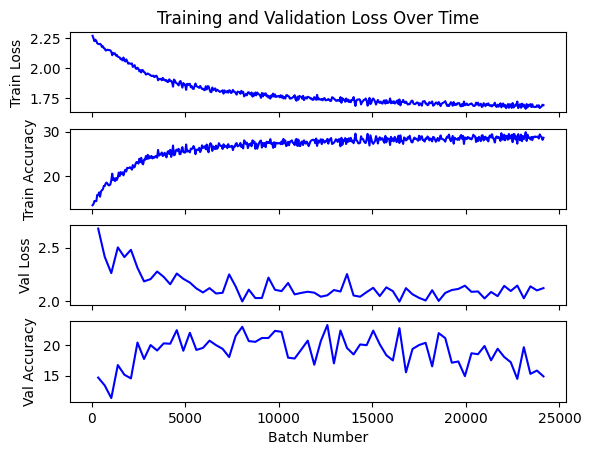

Epoch 70
Batch50, Loss: 1.682, Accuracy: 28.8%
Batch100, Loss: 1.673, Accuracy: 29.1%
Batch150, Loss: 1.669, Accuracy: 29.3%
Batch200, Loss: 1.675, Accuracy: 29.2%
Batch250, Loss: 1.691, Accuracy: 28.2%
Batch300, Loss: 1.677, Accuracy: 29.3%
Batch350, Loss: 1.714, Accuracy: 27.8%
Val Loss: 2.075, Val Accuracy: 18.8%
*****************************************



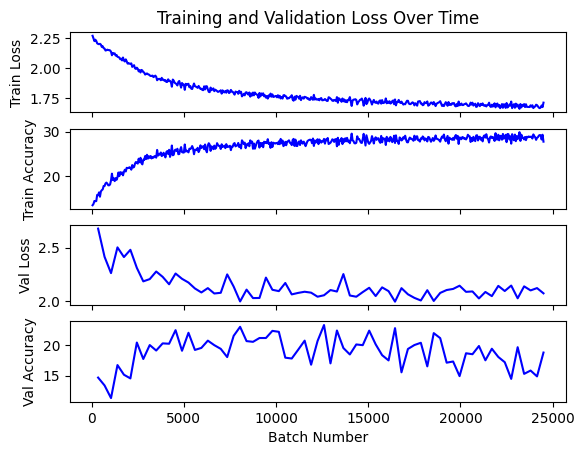

Epoch 71
Batch50, Loss: 1.665, Accuracy: 29.4%
Batch100, Loss: 1.698, Accuracy: 28.1%
Batch150, Loss: 1.678, Accuracy: 29.2%
Batch200, Loss: 1.676, Accuracy: 28.9%
Batch250, Loss: 1.699, Accuracy: 28.2%
Batch300, Loss: 1.671, Accuracy: 29.1%
Batch350, Loss: 1.669, Accuracy: 29.4%
Val Loss: 2.037, Val Accuracy: 20.1%
*****************************************



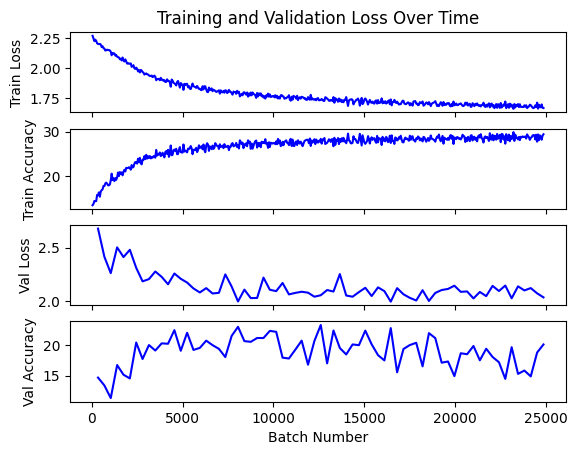

Epoch 72
Batch50, Loss: 1.701, Accuracy: 27.9%
Batch100, Loss: 1.678, Accuracy: 28.9%
Batch150, Loss: 1.682, Accuracy: 28.7%
Batch200, Loss: 1.664, Accuracy: 29.5%
Batch250, Loss: 1.672, Accuracy: 29.1%
Batch300, Loss: 1.679, Accuracy: 28.9%
Batch350, Loss: 1.687, Accuracy: 28.7%
Val Loss: 2.097, Val Accuracy: 15.2%
*****************************************



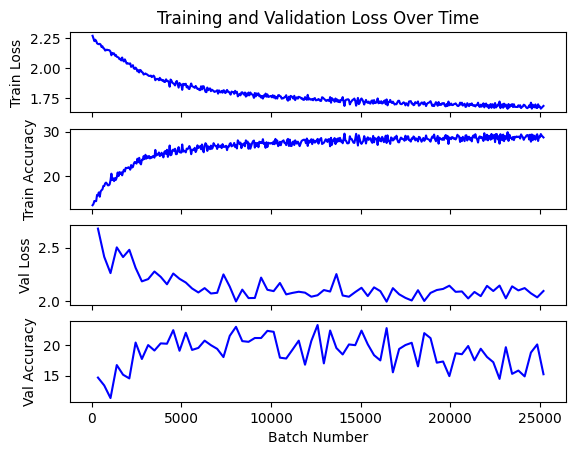

Epoch 73
Batch50, Loss: 1.682, Accuracy: 28.9%
Batch100, Loss: 1.700, Accuracy: 28.2%
Batch150, Loss: 1.676, Accuracy: 29.1%
Batch200, Loss: 1.658, Accuracy: 29.6%
Batch250, Loss: 1.679, Accuracy: 29.0%
Batch300, Loss: 1.697, Accuracy: 28.2%
Batch350, Loss: 1.676, Accuracy: 29.0%
Val Loss: 2.335, Val Accuracy: 13.7%
*****************************************



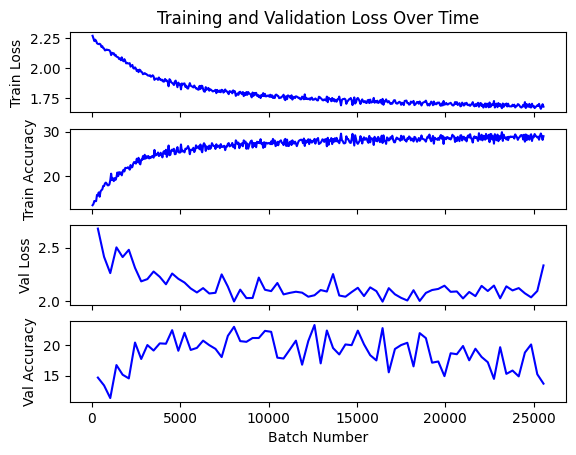

Epoch 74
Batch50, Loss: 1.646, Accuracy: 30.1%
Batch100, Loss: 1.689, Accuracy: 28.2%
Batch150, Loss: 1.691, Accuracy: 28.3%
Batch200, Loss: 1.665, Accuracy: 29.7%
Batch250, Loss: 1.692, Accuracy: 28.6%
Batch300, Loss: 1.670, Accuracy: 29.1%
Batch350, Loss: 1.699, Accuracy: 28.1%
Val Loss: 2.084, Val Accuracy: 17.8%
*****************************************



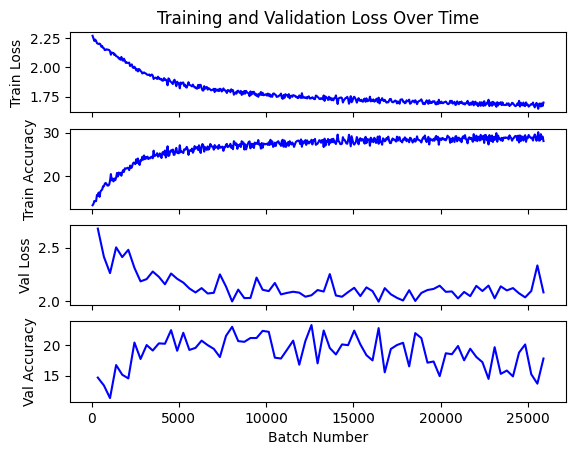

Epoch 75
Batch50, Loss: 1.676, Accuracy: 28.8%
Batch100, Loss: 1.671, Accuracy: 29.0%
Batch150, Loss: 1.687, Accuracy: 28.5%
Batch200, Loss: 1.674, Accuracy: 29.0%
Batch250, Loss: 1.692, Accuracy: 28.6%
Batch300, Loss: 1.671, Accuracy: 29.0%
Batch350, Loss: 1.669, Accuracy: 29.1%
Val Loss: 2.096, Val Accuracy: 15.7%
*****************************************



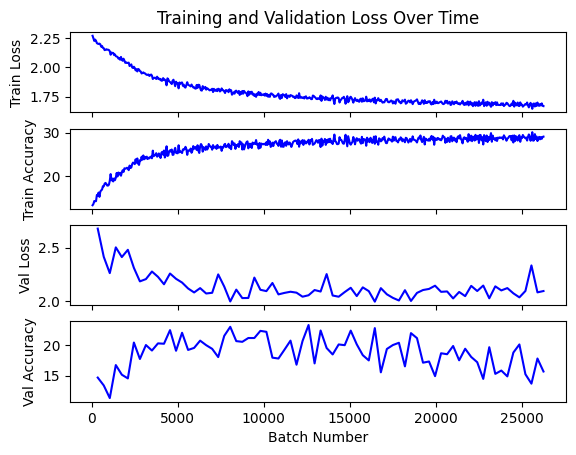

Epoch 76
Batch50, Loss: 1.687, Accuracy: 28.7%
Batch100, Loss: 1.680, Accuracy: 28.9%
Batch150, Loss: 1.650, Accuracy: 29.9%
Batch200, Loss: 1.666, Accuracy: 29.6%
Batch250, Loss: 1.703, Accuracy: 27.9%
Batch300, Loss: 1.680, Accuracy: 28.9%
Batch350, Loss: 1.688, Accuracy: 28.5%
Val Loss: 2.088, Val Accuracy: 16.8%
*****************************************



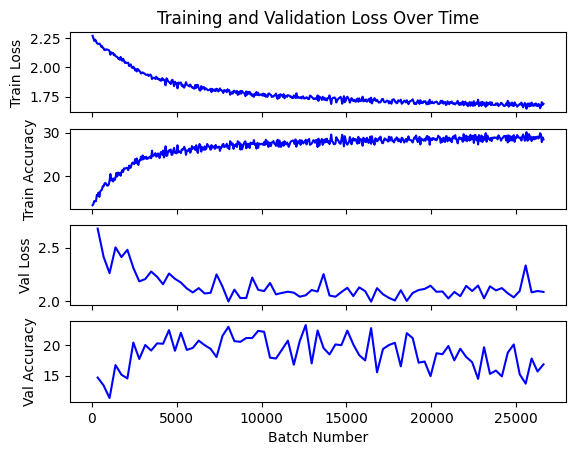

Epoch 77
Batch50, Loss: 1.675, Accuracy: 29.3%
Batch100, Loss: 1.695, Accuracy: 28.2%
Batch150, Loss: 1.666, Accuracy: 29.2%
Batch200, Loss: 1.655, Accuracy: 29.6%
Batch250, Loss: 1.666, Accuracy: 29.5%
Batch300, Loss: 1.677, Accuracy: 28.8%
Batch350, Loss: 1.696, Accuracy: 28.0%
Val Loss: 2.125, Val Accuracy: 15.8%
*****************************************



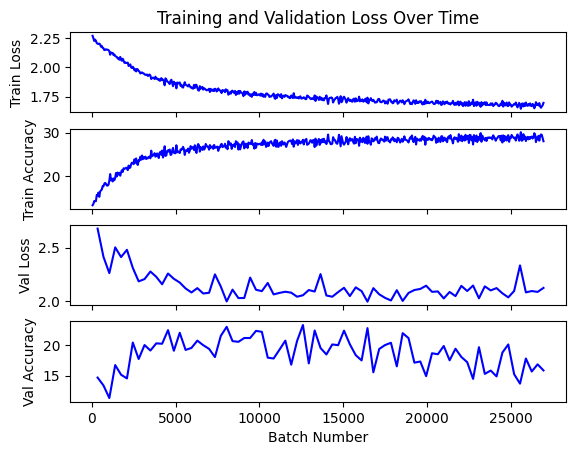

Epoch 78
Batch50, Loss: 1.659, Accuracy: 29.8%
Batch100, Loss: 1.666, Accuracy: 29.2%
Batch150, Loss: 1.675, Accuracy: 28.9%
Batch200, Loss: 1.677, Accuracy: 28.9%
Batch250, Loss: 1.666, Accuracy: 29.6%
Batch300, Loss: 1.696, Accuracy: 28.1%
Batch350, Loss: 1.691, Accuracy: 28.5%
Val Loss: 2.162, Val Accuracy: 18.6%
*****************************************



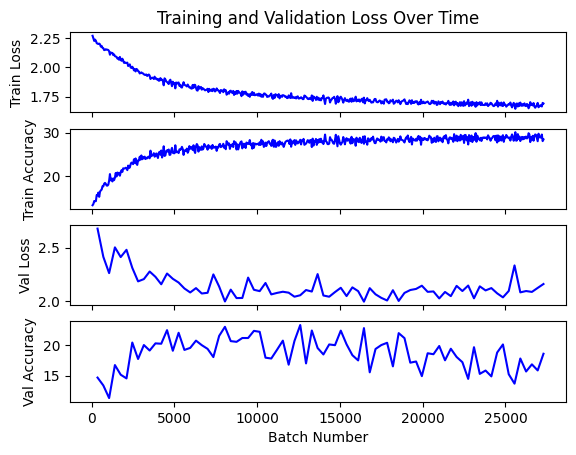

Epoch 79
Batch50, Loss: 1.673, Accuracy: 28.8%
Batch100, Loss: 1.636, Accuracy: 30.4%
Batch150, Loss: 1.696, Accuracy: 28.1%
Batch200, Loss: 1.680, Accuracy: 29.1%
Batch250, Loss: 1.669, Accuracy: 29.3%
Batch300, Loss: 1.680, Accuracy: 28.7%
Batch350, Loss: 1.682, Accuracy: 28.5%
Val Loss: 2.056, Val Accuracy: 18.8%
*****************************************



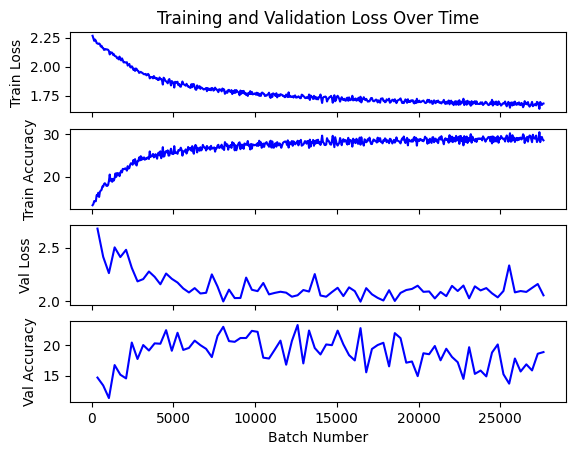

Epoch 80
Batch50, Loss: 1.650, Accuracy: 30.0%
Batch100, Loss: 1.686, Accuracy: 28.7%
Batch150, Loss: 1.700, Accuracy: 27.8%
Batch200, Loss: 1.672, Accuracy: 28.8%
Batch250, Loss: 1.681, Accuracy: 28.6%
Batch300, Loss: 1.670, Accuracy: 29.1%
Batch350, Loss: 1.659, Accuracy: 29.6%
Val Loss: 2.172, Val Accuracy: 13.4%
*****************************************



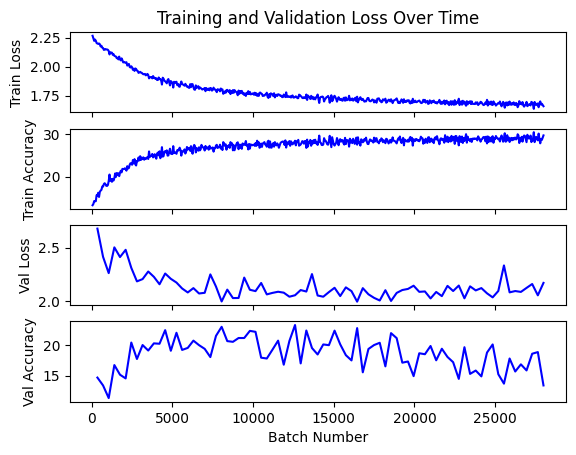

Epoch 81
Batch50, Loss: 1.668, Accuracy: 29.0%
Batch100, Loss: 1.671, Accuracy: 28.8%
Batch150, Loss: 1.660, Accuracy: 29.5%
Batch200, Loss: 1.687, Accuracy: 28.3%
Batch250, Loss: 1.670, Accuracy: 29.2%
Batch300, Loss: 1.675, Accuracy: 28.9%
Batch350, Loss: 1.692, Accuracy: 28.4%
Val Loss: 2.278, Val Accuracy: 13.6%
*****************************************



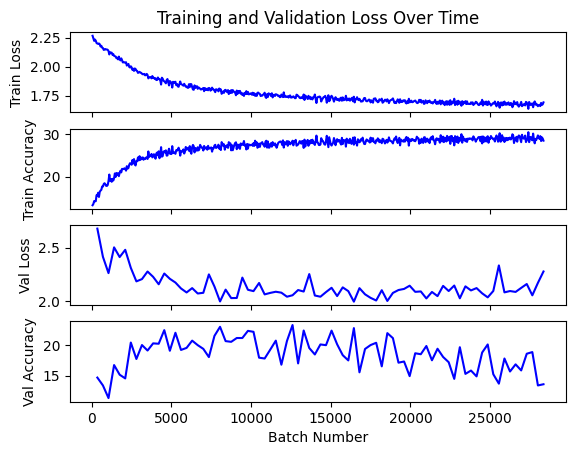

Epoch 82
Batch50, Loss: 1.675, Accuracy: 28.8%
Batch100, Loss: 1.676, Accuracy: 28.6%
Batch150, Loss: 1.680, Accuracy: 28.5%
Batch200, Loss: 1.671, Accuracy: 29.1%
Batch250, Loss: 1.683, Accuracy: 28.4%
Batch300, Loss: 1.667, Accuracy: 29.2%
Batch350, Loss: 1.676, Accuracy: 29.0%
Val Loss: 2.055, Val Accuracy: 19.9%
*****************************************



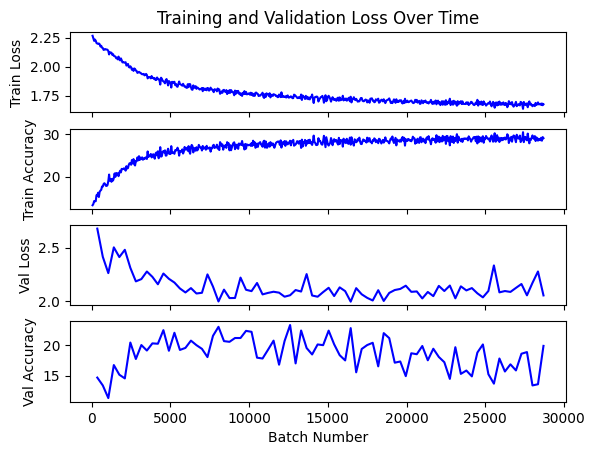

Epoch 83
Batch50, Loss: 1.664, Accuracy: 29.2%
Batch100, Loss: 1.659, Accuracy: 29.6%
Batch150, Loss: 1.652, Accuracy: 29.7%
Batch200, Loss: 1.678, Accuracy: 28.6%
Batch250, Loss: 1.674, Accuracy: 28.9%
Batch300, Loss: 1.690, Accuracy: 28.1%
Batch350, Loss: 1.669, Accuracy: 28.9%
Val Loss: 2.233, Val Accuracy: 23.2%
*****************************************



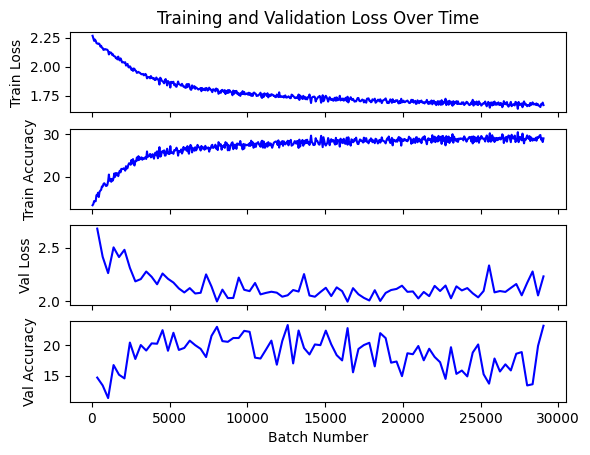

Epoch 84
Batch50, Loss: 1.670, Accuracy: 29.2%
Batch100, Loss: 1.665, Accuracy: 29.2%
Batch150, Loss: 1.666, Accuracy: 29.3%
Batch200, Loss: 1.654, Accuracy: 29.7%
Batch250, Loss: 1.684, Accuracy: 28.5%
Batch300, Loss: 1.674, Accuracy: 28.9%
Batch350, Loss: 1.687, Accuracy: 28.4%
Val Loss: 2.131, Val Accuracy: 15.2%
*****************************************



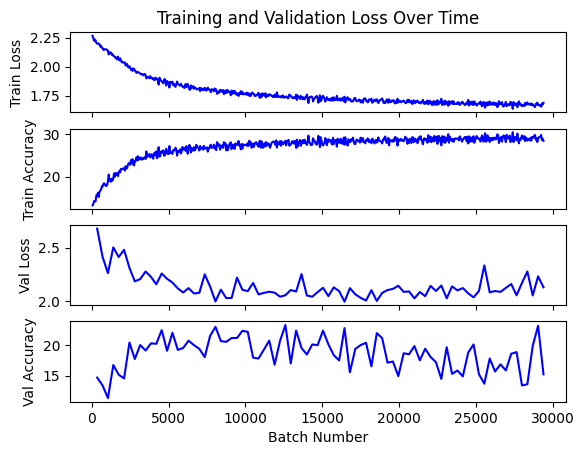

Epoch 85
Batch50, Loss: 1.678, Accuracy: 28.7%
Batch100, Loss: 1.669, Accuracy: 29.0%
Batch150, Loss: 1.665, Accuracy: 29.0%
Batch200, Loss: 1.666, Accuracy: 28.9%
Batch250, Loss: 1.682, Accuracy: 28.8%
Batch300, Loss: 1.667, Accuracy: 29.4%
Batch350, Loss: 1.675, Accuracy: 28.8%
Val Loss: 2.098, Val Accuracy: 16.9%
*****************************************



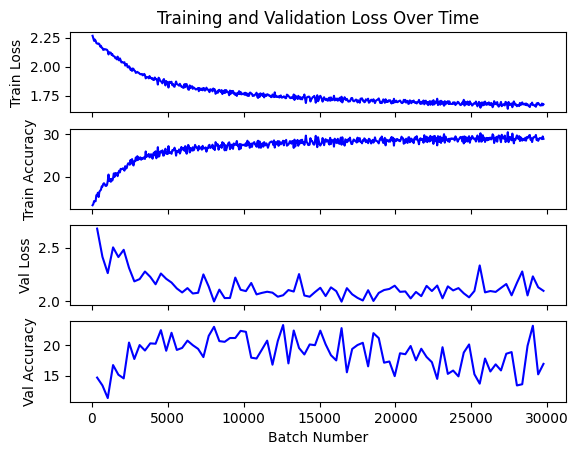

Epoch 86
Batch50, Loss: 1.651, Accuracy: 29.8%
Batch100, Loss: 1.673, Accuracy: 29.2%
Batch150, Loss: 1.671, Accuracy: 29.1%
Batch200, Loss: 1.667, Accuracy: 28.9%
Batch250, Loss: 1.647, Accuracy: 29.7%
Batch300, Loss: 1.685, Accuracy: 28.2%
Batch350, Loss: 1.686, Accuracy: 28.4%
Val Loss: 2.200, Val Accuracy: 16.4%
*****************************************



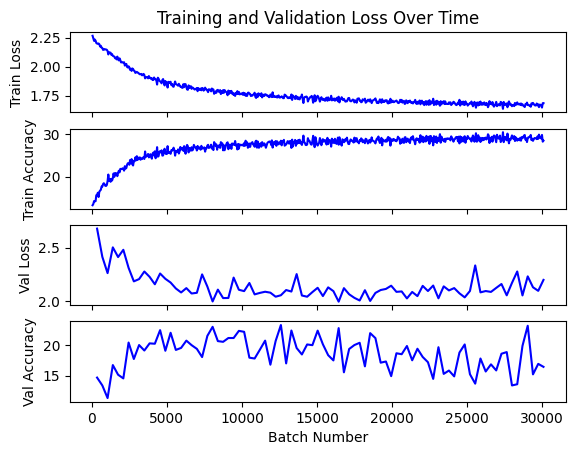

Epoch 87
Batch50, Loss: 1.676, Accuracy: 28.8%
Batch100, Loss: 1.689, Accuracy: 28.0%
Batch150, Loss: 1.657, Accuracy: 29.4%
Batch200, Loss: 1.686, Accuracy: 28.5%
Batch250, Loss: 1.663, Accuracy: 29.0%
Batch300, Loss: 1.649, Accuracy: 29.7%
Batch350, Loss: 1.662, Accuracy: 29.5%
Val Loss: 2.124, Val Accuracy: 16.2%
*****************************************



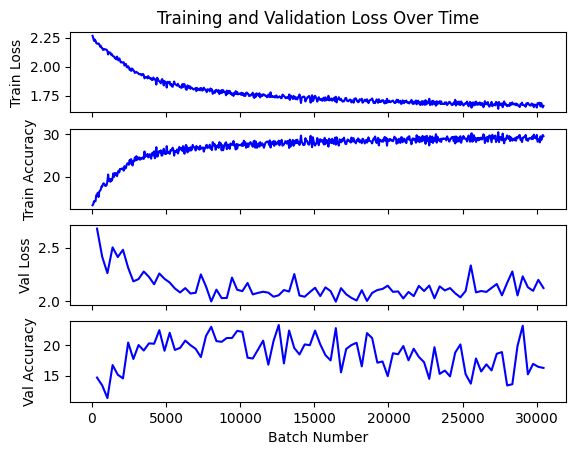

Epoch 88
Batch50, Loss: 1.675, Accuracy: 28.7%
Batch100, Loss: 1.671, Accuracy: 28.9%
Batch150, Loss: 1.662, Accuracy: 29.2%
Batch200, Loss: 1.645, Accuracy: 30.2%
Batch250, Loss: 1.697, Accuracy: 27.7%
Batch300, Loss: 1.658, Accuracy: 29.5%
Batch350, Loss: 1.668, Accuracy: 29.1%
Val Loss: 2.135, Val Accuracy: 16.0%
*****************************************



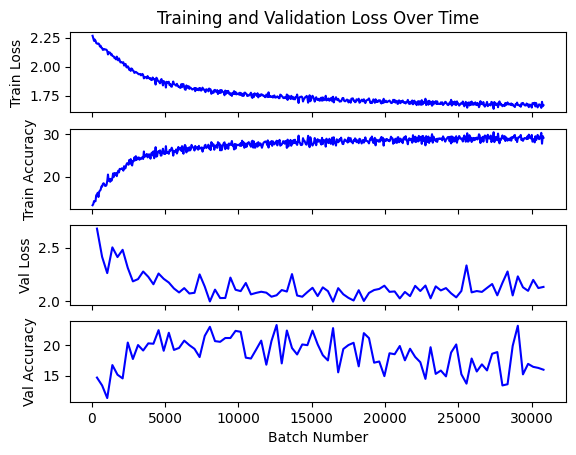

Epoch 89
Batch50, Loss: 1.676, Accuracy: 28.6%
Batch100, Loss: 1.662, Accuracy: 29.2%
Batch150, Loss: 1.672, Accuracy: 28.9%
Batch200, Loss: 1.660, Accuracy: 29.6%
Batch250, Loss: 1.681, Accuracy: 28.5%
Batch300, Loss: 1.664, Accuracy: 29.1%
Batch350, Loss: 1.659, Accuracy: 29.4%
Val Loss: 2.106, Val Accuracy: 15.6%
*****************************************



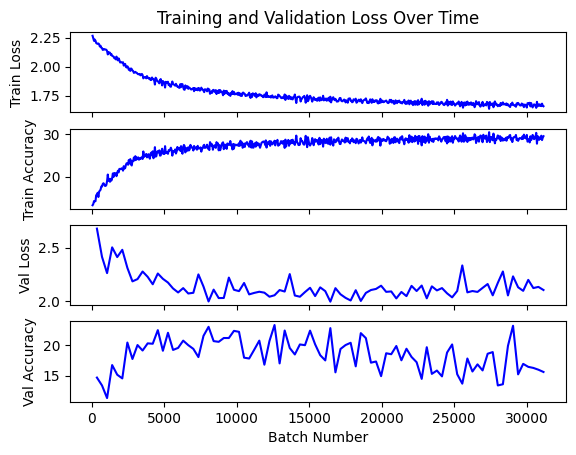

Epoch 90
Batch50, Loss: 1.648, Accuracy: 29.5%
Batch100, Loss: 1.670, Accuracy: 28.8%
Batch150, Loss: 1.679, Accuracy: 28.8%
Batch200, Loss: 1.666, Accuracy: 29.1%
Batch250, Loss: 1.679, Accuracy: 28.8%
Batch300, Loss: 1.691, Accuracy: 28.4%
Batch350, Loss: 1.651, Accuracy: 30.0%
Val Loss: 2.085, Val Accuracy: 16.9%
*****************************************



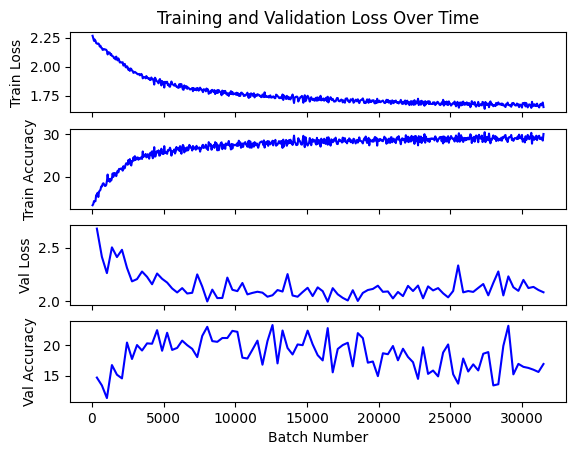

Epoch 91
Batch50, Loss: 1.657, Accuracy: 29.2%
Batch100, Loss: 1.650, Accuracy: 29.6%
Batch150, Loss: 1.658, Accuracy: 29.3%
Batch200, Loss: 1.667, Accuracy: 29.1%
Batch250, Loss: 1.690, Accuracy: 28.2%
Batch300, Loss: 1.663, Accuracy: 29.2%
Batch350, Loss: 1.674, Accuracy: 28.8%
Val Loss: 2.169, Val Accuracy: 13.5%
*****************************************



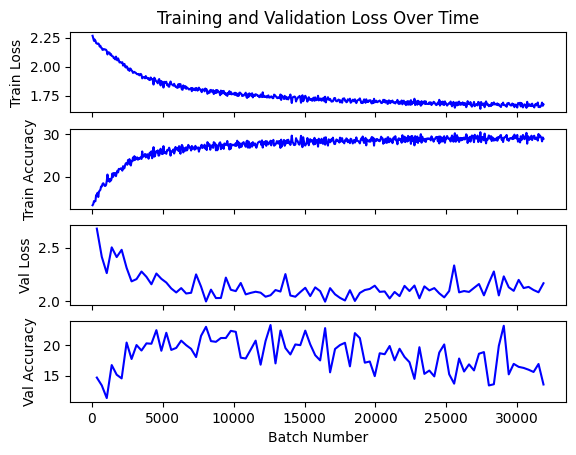

Epoch 92
Batch50, Loss: 1.685, Accuracy: 28.5%
Batch100, Loss: 1.678, Accuracy: 28.4%
Batch150, Loss: 1.630, Accuracy: 30.5%
Batch200, Loss: 1.670, Accuracy: 28.5%
Batch250, Loss: 1.663, Accuracy: 29.2%
Batch300, Loss: 1.658, Accuracy: 29.3%
Batch350, Loss: 1.663, Accuracy: 29.2%
Val Loss: 2.134, Val Accuracy: 15.0%
*****************************************



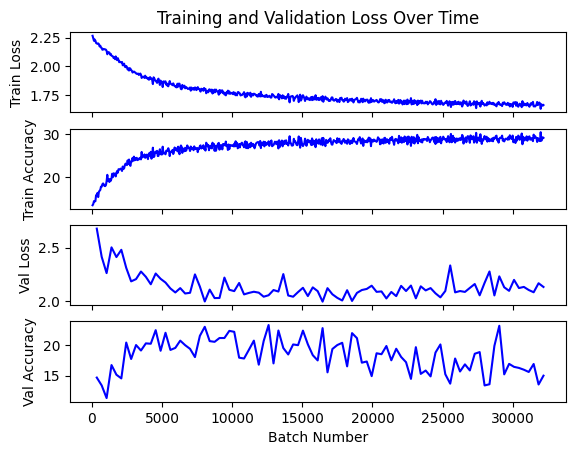

Epoch 93
Batch50, Loss: 1.650, Accuracy: 29.5%
Batch100, Loss: 1.669, Accuracy: 29.0%
Batch150, Loss: 1.668, Accuracy: 29.0%
Batch200, Loss: 1.684, Accuracy: 28.3%
Batch250, Loss: 1.667, Accuracy: 29.0%
Batch300, Loss: 1.674, Accuracy: 28.8%
Batch350, Loss: 1.653, Accuracy: 29.7%
Val Loss: 2.169, Val Accuracy: 16.3%
*****************************************



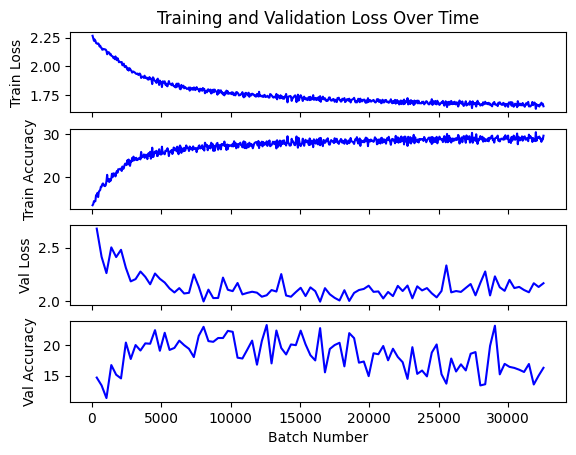

Epoch 94
Batch50, Loss: 1.664, Accuracy: 29.3%
Batch100, Loss: 1.673, Accuracy: 28.7%
Batch150, Loss: 1.674, Accuracy: 28.7%
Batch200, Loss: 1.666, Accuracy: 29.1%
Batch250, Loss: 1.662, Accuracy: 29.5%
Batch300, Loss: 1.642, Accuracy: 30.3%
Batch350, Loss: 1.679, Accuracy: 28.5%
Val Loss: 2.116, Val Accuracy: 16.2%
*****************************************



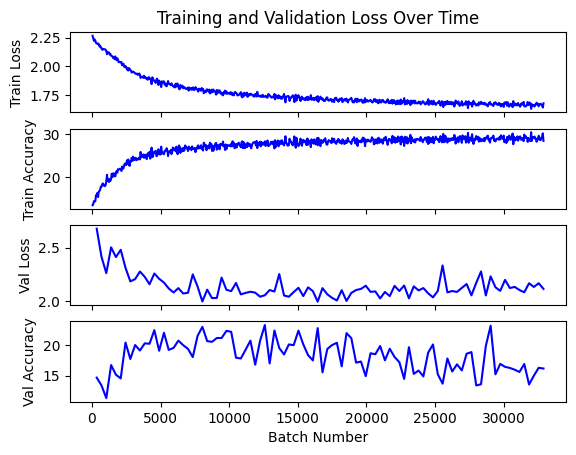

Epoch 95
Batch50, Loss: 1.670, Accuracy: 28.6%
Batch100, Loss: 1.665, Accuracy: 28.9%
Batch150, Loss: 1.649, Accuracy: 29.7%
Batch200, Loss: 1.648, Accuracy: 29.8%
Batch250, Loss: 1.666, Accuracy: 28.9%
Batch300, Loss: 1.661, Accuracy: 29.1%
Batch350, Loss: 1.680, Accuracy: 28.5%
Val Loss: 2.063, Val Accuracy: 17.4%
*****************************************



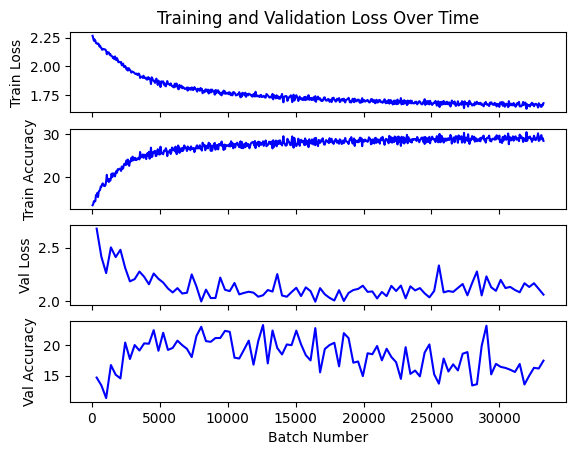

Epoch 96
Batch50, Loss: 1.639, Accuracy: 30.0%
Batch100, Loss: 1.672, Accuracy: 28.7%
Batch150, Loss: 1.684, Accuracy: 28.2%
Batch200, Loss: 1.648, Accuracy: 29.7%
Batch250, Loss: 1.650, Accuracy: 29.5%
Batch300, Loss: 1.649, Accuracy: 29.9%
Batch350, Loss: 1.692, Accuracy: 27.8%
Val Loss: 2.095, Val Accuracy: 17.7%
*****************************************



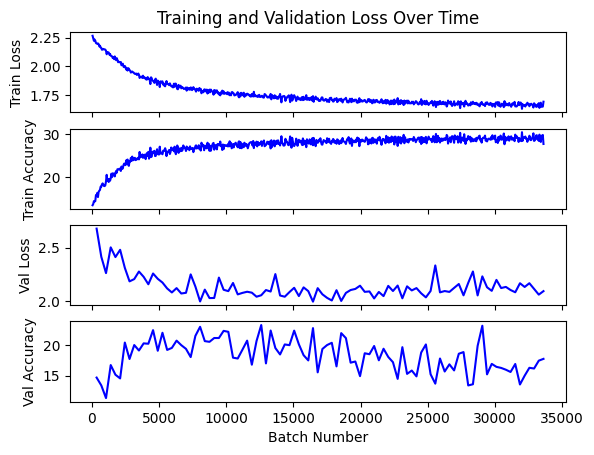

Epoch 97
Batch50, Loss: 1.648, Accuracy: 29.9%
Batch100, Loss: 1.651, Accuracy: 29.5%
Batch150, Loss: 1.658, Accuracy: 29.3%
Batch200, Loss: 1.661, Accuracy: 29.2%
Batch250, Loss: 1.674, Accuracy: 28.9%
Batch300, Loss: 1.664, Accuracy: 29.0%
Batch350, Loss: 1.669, Accuracy: 28.7%
Val Loss: 2.107, Val Accuracy: 17.1%
*****************************************



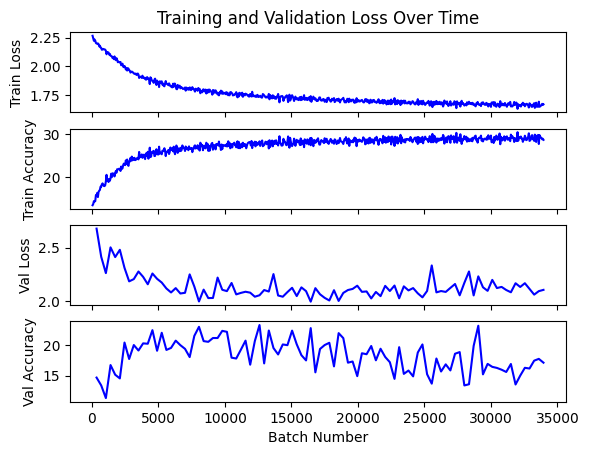

Epoch 98
Batch50, Loss: 1.640, Accuracy: 30.0%
Batch100, Loss: 1.657, Accuracy: 29.3%
Batch150, Loss: 1.650, Accuracy: 29.4%
Batch200, Loss: 1.662, Accuracy: 29.2%
Batch250, Loss: 1.686, Accuracy: 28.1%
Batch300, Loss: 1.673, Accuracy: 28.8%
Batch350, Loss: 1.668, Accuracy: 28.9%
Val Loss: 2.116, Val Accuracy: 17.1%
*****************************************



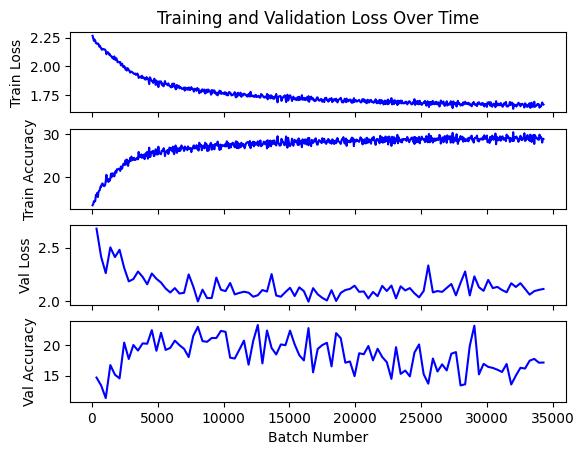

Epoch 99
Batch50, Loss: 1.647, Accuracy: 29.9%
Batch100, Loss: 1.681, Accuracy: 28.3%
Batch150, Loss: 1.682, Accuracy: 28.2%
Batch200, Loss: 1.653, Accuracy: 29.5%
Batch250, Loss: 1.648, Accuracy: 29.8%
Batch300, Loss: 1.666, Accuracy: 29.0%
Batch350, Loss: 1.663, Accuracy: 29.2%
Val Loss: 2.095, Val Accuracy: 17.2%
*****************************************



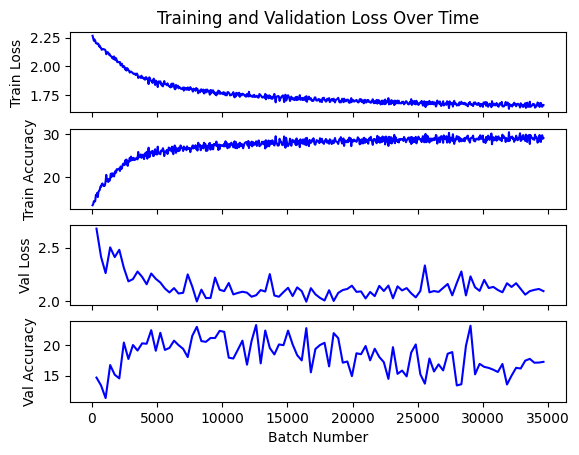

Epoch 100
Batch50, Loss: 1.658, Accuracy: 29.1%
Batch100, Loss: 1.663, Accuracy: 29.3%
Batch150, Loss: 1.652, Accuracy: 29.9%
Batch200, Loss: 1.676, Accuracy: 28.7%
Batch250, Loss: 1.667, Accuracy: 28.8%
Batch300, Loss: 1.627, Accuracy: 30.6%
Batch350, Loss: 1.693, Accuracy: 27.8%
Val Loss: 2.124, Val Accuracy: 16.8%
*****************************************



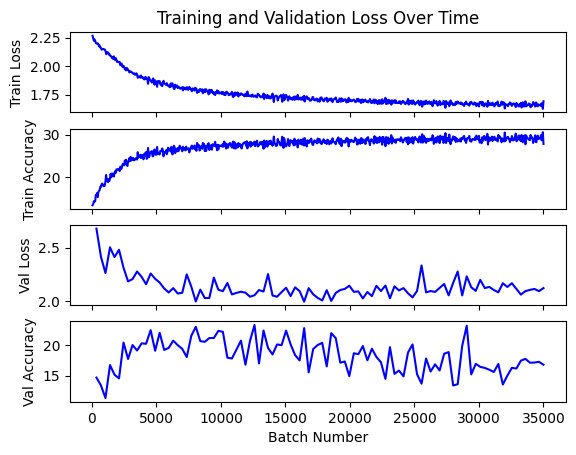

Epoch 101
Batch50, Loss: 1.675, Accuracy: 28.5%
Batch100, Loss: 1.653, Accuracy: 29.4%
Batch150, Loss: 1.651, Accuracy: 29.3%
Batch200, Loss: 1.645, Accuracy: 29.7%
Batch250, Loss: 1.651, Accuracy: 29.7%
Batch300, Loss: 1.651, Accuracy: 29.7%
Batch350, Loss: 1.679, Accuracy: 28.2%
Val Loss: 2.128, Val Accuracy: 15.0%
*****************************************



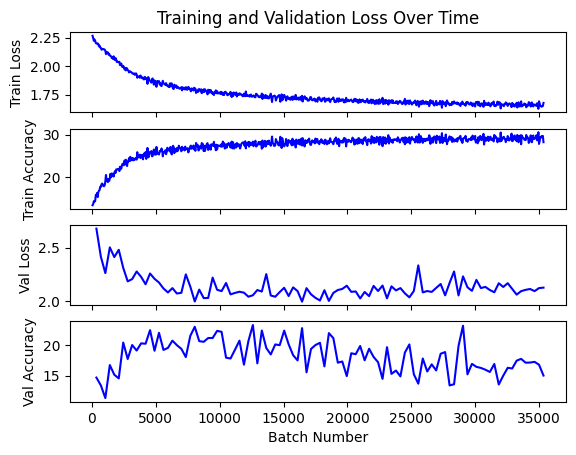

Epoch 102
Batch50, Loss: 1.654, Accuracy: 29.3%
Batch100, Loss: 1.665, Accuracy: 28.7%
Batch150, Loss: 1.644, Accuracy: 29.9%
Batch200, Loss: 1.655, Accuracy: 29.2%
Batch250, Loss: 1.643, Accuracy: 29.9%
Batch300, Loss: 1.672, Accuracy: 28.6%
Batch350, Loss: 1.671, Accuracy: 28.8%
Val Loss: 2.188, Val Accuracy: 16.6%
*****************************************



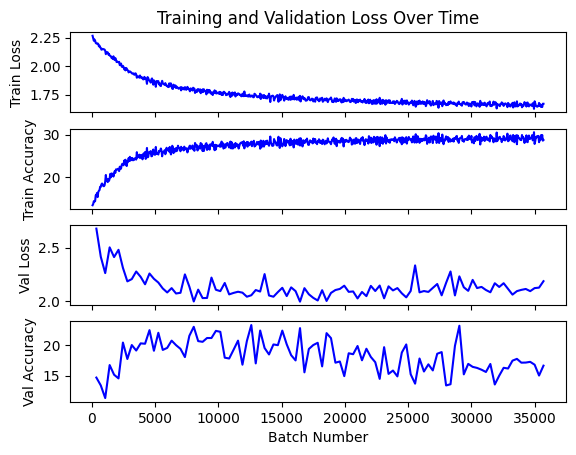

Epoch 103
Batch50, Loss: 1.656, Accuracy: 29.3%
Batch100, Loss: 1.650, Accuracy: 29.7%
Batch150, Loss: 1.669, Accuracy: 28.9%
Batch200, Loss: 1.641, Accuracy: 30.1%
Batch250, Loss: 1.666, Accuracy: 28.9%
Batch300, Loss: 1.675, Accuracy: 28.3%
Batch350, Loss: 1.653, Accuracy: 29.2%
Val Loss: 2.106, Val Accuracy: 18.6%
*****************************************



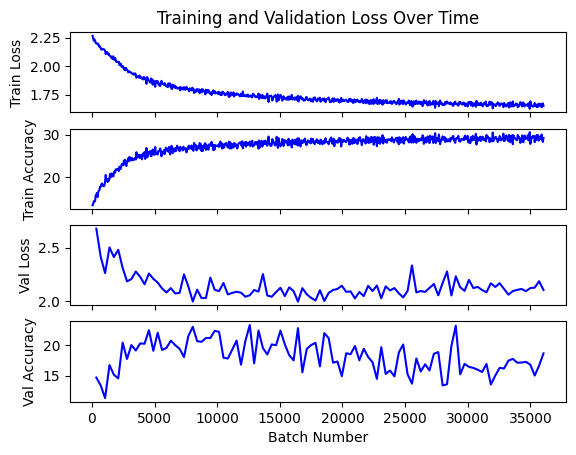

Epoch 104
Batch50, Loss: 1.652, Accuracy: 29.6%
Batch100, Loss: 1.663, Accuracy: 29.2%
Batch150, Loss: 1.653, Accuracy: 29.5%
Batch200, Loss: 1.664, Accuracy: 28.8%
Batch250, Loss: 1.644, Accuracy: 29.9%
Batch300, Loss: 1.671, Accuracy: 28.9%
Batch350, Loss: 1.687, Accuracy: 28.2%
Val Loss: 2.065, Val Accuracy: 17.7%
*****************************************



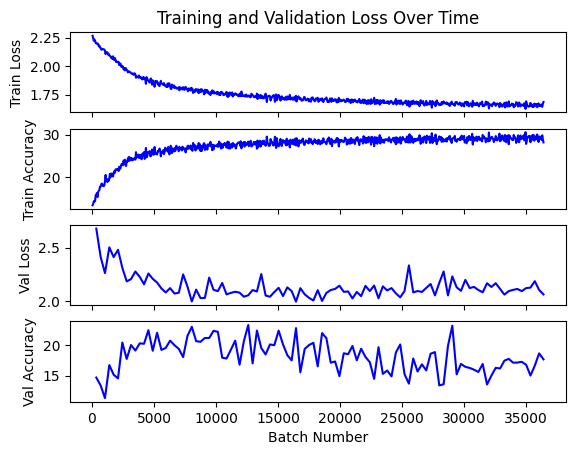

Epoch 105
Batch50, Loss: 1.666, Accuracy: 28.7%
Batch100, Loss: 1.675, Accuracy: 28.5%
Batch150, Loss: 1.650, Accuracy: 29.8%
Batch200, Loss: 1.647, Accuracy: 29.6%
Batch250, Loss: 1.660, Accuracy: 29.1%
Batch300, Loss: 1.668, Accuracy: 29.0%
Batch350, Loss: 1.667, Accuracy: 28.9%
Val Loss: 2.177, Val Accuracy: 16.4%
*****************************************



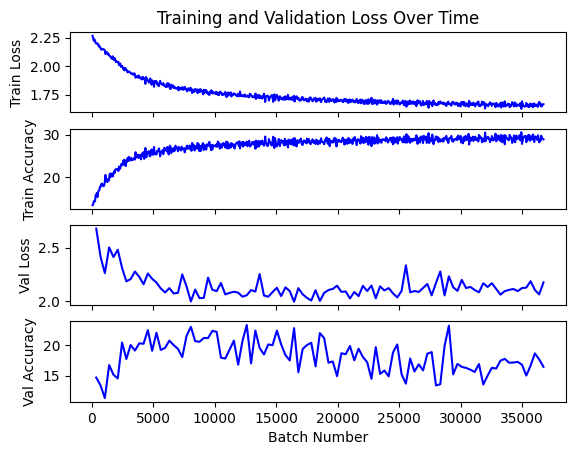

Epoch 106
Batch50, Loss: 1.647, Accuracy: 29.5%
Batch100, Loss: 1.659, Accuracy: 29.1%
Batch150, Loss: 1.656, Accuracy: 29.4%
Batch200, Loss: 1.660, Accuracy: 28.9%
Batch250, Loss: 1.666, Accuracy: 28.8%
Batch300, Loss: 1.666, Accuracy: 29.0%
Batch350, Loss: 1.637, Accuracy: 30.1%
Val Loss: 2.184, Val Accuracy: 17.0%
*****************************************



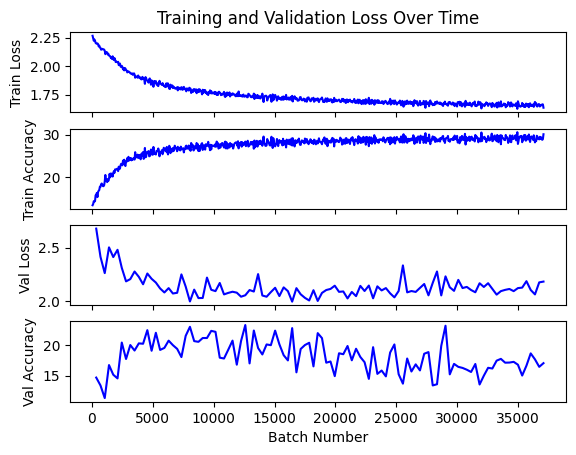

Epoch 107
Batch50, Loss: 1.660, Accuracy: 28.9%
Batch100, Loss: 1.642, Accuracy: 29.8%
Batch150, Loss: 1.662, Accuracy: 28.9%
Batch200, Loss: 1.644, Accuracy: 29.7%
Batch250, Loss: 1.688, Accuracy: 28.1%
Batch300, Loss: 1.643, Accuracy: 29.9%
Batch350, Loss: 1.660, Accuracy: 29.4%
Val Loss: 2.200, Val Accuracy: 17.1%
*****************************************



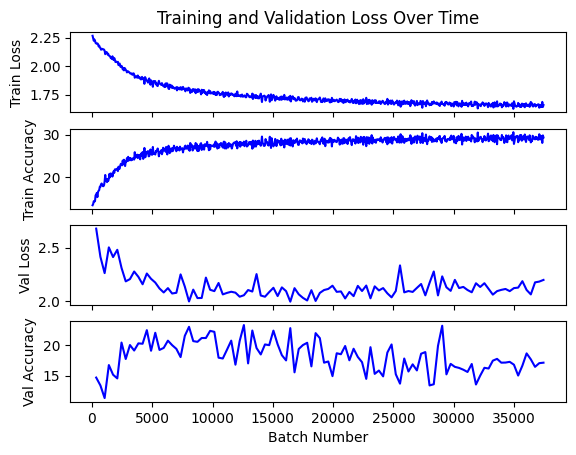

Epoch 108
Batch50, Loss: 1.654, Accuracy: 29.4%
Batch100, Loss: 1.658, Accuracy: 29.1%
Batch150, Loss: 1.646, Accuracy: 29.6%
Batch200, Loss: 1.644, Accuracy: 29.7%
Batch250, Loss: 1.671, Accuracy: 28.7%
Batch300, Loss: 1.668, Accuracy: 28.8%
Batch350, Loss: 1.662, Accuracy: 29.3%
Val Loss: 2.107, Val Accuracy: 18.4%
*****************************************



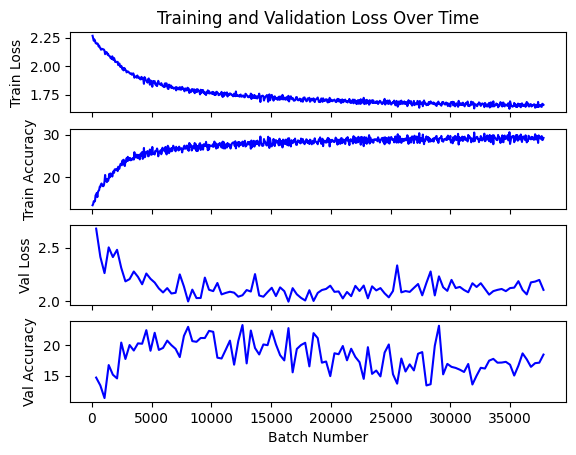

Epoch 109
Batch50, Loss: 1.649, Accuracy: 29.5%
Batch100, Loss: 1.658, Accuracy: 29.3%
Batch150, Loss: 1.648, Accuracy: 29.6%
Batch200, Loss: 1.665, Accuracy: 28.7%
Batch250, Loss: 1.640, Accuracy: 30.0%
Batch300, Loss: 1.679, Accuracy: 28.2%
Batch350, Loss: 1.654, Accuracy: 29.2%
Val Loss: 2.194, Val Accuracy: 18.2%
*****************************************



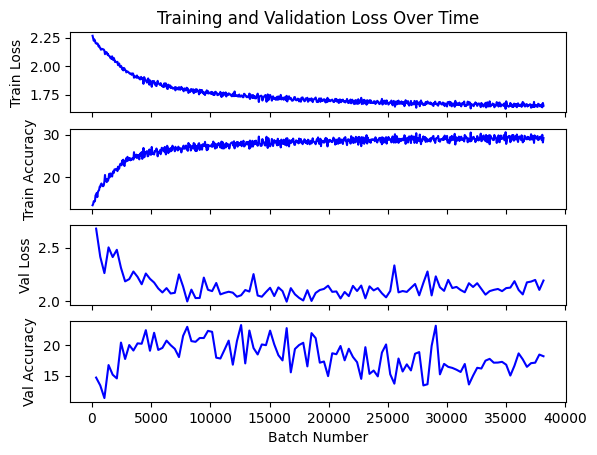

Epoch 110
Batch50, Loss: 1.647, Accuracy: 29.3%
Batch100, Loss: 1.641, Accuracy: 29.9%
Batch150, Loss: 1.652, Accuracy: 29.4%
Batch200, Loss: 1.672, Accuracy: 28.4%
Batch250, Loss: 1.662, Accuracy: 29.2%
Batch300, Loss: 1.652, Accuracy: 29.5%
Batch350, Loss: 1.661, Accuracy: 29.1%
Val Loss: 2.133, Val Accuracy: 14.8%
*****************************************



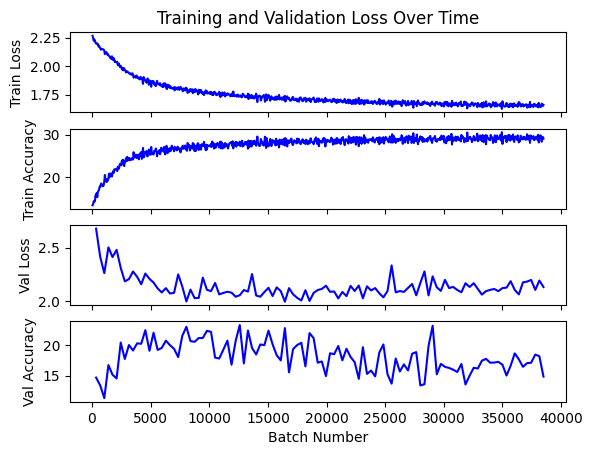

Epoch 111
Batch50, Loss: 1.645, Accuracy: 29.6%
Batch100, Loss: 1.651, Accuracy: 29.4%
Batch150, Loss: 1.645, Accuracy: 29.6%
Batch200, Loss: 1.668, Accuracy: 28.7%
Batch250, Loss: 1.660, Accuracy: 29.0%
Batch300, Loss: 1.656, Accuracy: 29.3%
Batch350, Loss: 1.658, Accuracy: 29.2%
Val Loss: 2.148, Val Accuracy: 17.4%
*****************************************



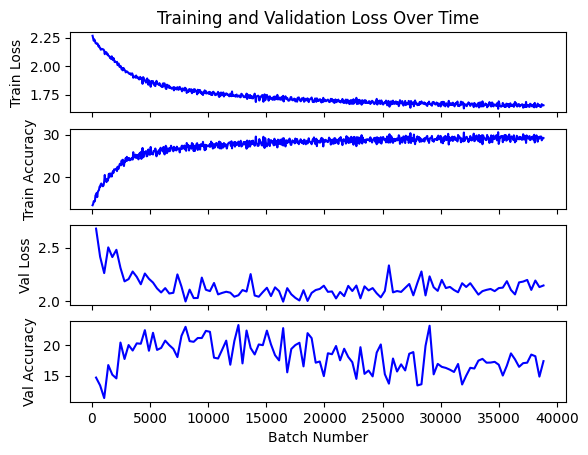

Epoch 112
Batch50, Loss: 1.646, Accuracy: 29.7%
Batch100, Loss: 1.651, Accuracy: 29.6%
Batch150, Loss: 1.671, Accuracy: 29.0%
Batch200, Loss: 1.658, Accuracy: 29.0%
Batch250, Loss: 1.644, Accuracy: 29.6%
Batch300, Loss: 1.669, Accuracy: 28.8%
Batch350, Loss: 1.652, Accuracy: 29.3%
Val Loss: 2.150, Val Accuracy: 15.7%
*****************************************



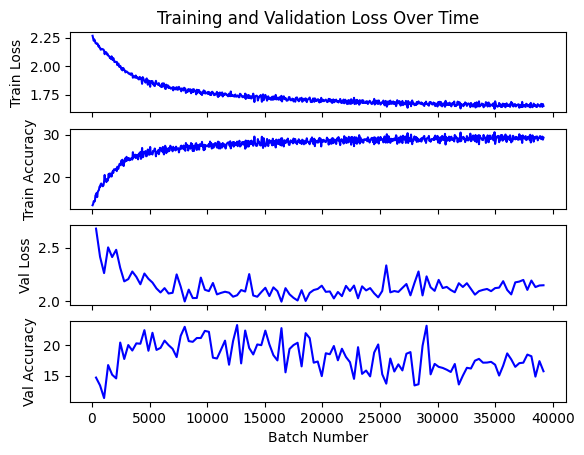

Epoch 113


KeyboardInterrupt: 

In [23]:
#Sets up CNN, optimizer, and loss function
resnet = Resnet()
resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[91, 136], gamma=0.1)
#optimizer = optim.Adam(resnet.parameters(), lr=0.0001)

batches_training = np.array([])
losses_training = np.array([])
accuracies_training  = np.array([])
batches_validation = np.array([])
losses_validation = np.array([])
accuracies_validation = np.array([])

fig = None

#Trains the CNN
num_epochs = 182
for i in range(num_epochs):
    print(f"Epoch {i+1}")
    batches_toadd, losses_toadd, accuracy_toadd = train_epoch(resnet, optimizer, criterion)
    last_batch_num = 0 if len(batches_training) == 0 else batches_training[-1]
    batches_training = np.append(batches_training, (np.array(batches_toadd) + last_batch_num + 1))
    losses_training = np.append(losses_training, losses_toadd)
    accuracies_training = np.append(accuracies_training, accuracy_toadd)

    losses_toadd, accuracy_toadd = validate_epoch(resnet, criterion)
    batches_validation = np.append(batches_validation, batches_training[-1])
    losses_validation = np.append(losses_validation, losses_toadd)
    accuracies_validation = np.append(accuracies_validation, accuracy_toadd)

    #Plot
    if fig:
        plt.close(fig)
    fig = new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation)
    
plt.show()

# Save the loss data so that we can process/graph it later
folder_path = "Resnet1"
os.makedirs(folder_path, exist_ok=True)

to_save = {
    "batches_training": batches_training,
    "losses_training": losses_training,
    "accuracies_training": accuracies_training,
    "batches_validation": batches_validation,
    "losses_validation": losses_validation,
    "accuracies_validation": accuracies_validation
}

for name, array in to_save.items():
    file_path = os.path.join(folder_path, f"{name}.npy")
    np.save(file_path, array)
    print(f"Saved {name} to {file_path}")




In [18]:
#Verifies accuracy on test data set
total_correct = 0
total = 0
resnet.train(False)
for batch_index, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(inputs)
        total_correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        total += len(outputs)
print(f"Accuracy {(total_correct/total) * 100}")

Accuracy 75.15900636025441


In [ ]:
torch.save(resnet, 'DeepResNetParams.pth')

In [ ]:
#Loads previously trained models
with torch.serialization.safe_globals([Resnet]):
    resnet = torch.load('DeepResNetParams.pth', weights_only=False)
resnet.to(device)

In [3]:
test_iter = iter(trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label: truck


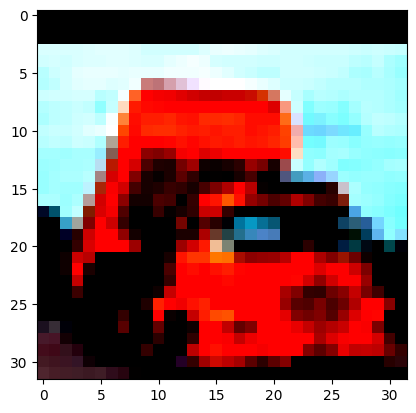

In [8]:
#Shows an image along with a guess and true label
images, true_labels = next(test_iter)
#resnet.train(False)
#guess_labels = resnet(images.to(device))
np_imgs = images.numpy()
np_img = np_imgs[0]
#guess_label = torch.argmax(guess_labels[0]).item()
print(f"True label: {class_names[true_labels[0]]}")
#print(f"Guess label: {class_names[guess_label]}")
plt.imshow(np_img.transpose((1, 2, 0)))